In [1]:
#Created on Fri Apr 9th 2021

#%%

#Import general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Import libraries useful for building the pipeline and join their branches
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin


#import modules created for data preparation phase
import my_utils
import missing_val_imput
import feature_select
import preprocessing
import adhoc_transf

#import libraries for data preparation phase
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder


#import libraries from modelling phase
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef

#import classifiers
#import Ensemble Trees Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
import xgboost as xgb

#to save model fit with GridSearchCV and avoid longer waits
import joblib


In [2]:

#Loading the dataset
#path_data: XXX
path_data=r'C:\Users\k5000751\OneDrive - Epedu O365\SeAMK\GitHub\Chronic_Kidney_Disease_Predictor\kidney_disease.csv'

df=pd.read_csv(path_data)
df.head()


id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...   pcv      wc   rc  htn   dm  cad  appet   pe  ane classification  
0  ...  44.0  7800.0  5.2  yes  yes   no   good   no   no            ckd  
1  ...  38.0  6000.0  NaN   no   no   no   good   no   no            ckd  
2  ...  31.0  7500.0  NaN   no  yes   no   poor   no  yes            ckd  
3  ...  32.0  6700.0  3.9  yes   no   no   poor  yes  yes            ckd  
4  ...  35.0  7300.0  4.6   no   no   no   good   no   no            ckd  

[5 rows x 26 columns]

In [3]:
target_feature='classification'
numerical_feats=['age','bp','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']
nominal_feats=['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
ordinal_feats=['sg','al','su',]

len_numerical_feats=len(numerical_feats)
len_nominal_feats=len(nominal_feats)
len_ordinal_feats=len(ordinal_feats)

######################################
#Step 0: Perform EDA to detect missing values, imbalanced data, strange characters,etc.
#############################

In [4]:
##Statistical analysis
df.describe()

id         age          bp          sg          al          su  \
count  400.000000  391.000000  388.000000  353.000000  354.000000  351.000000   
mean   199.500000   51.483376   76.469072    1.017408    1.016949    0.450142   
std    115.614301   17.169714   13.683637    0.005717    1.352679    1.099191   
min      0.000000    2.000000   50.000000    1.005000    0.000000    0.000000   
25%     99.750000   42.000000   70.000000    1.010000    0.000000    0.000000   
50%    199.500000   55.000000   80.000000    1.020000    0.000000    0.000000   
75%    299.250000   64.500000   80.000000    1.020000    2.000000    0.000000   
max    399.000000   90.000000  180.000000    1.025000    5.000000    5.000000   

              bgr          bu          sc         sod         pot        hemo  \
count  356.000000  381.000000  383.000000  313.000000  312.000000  348.000000   
mean   148.036517   57.425722    3.072454  137.528754    4.627244   12.526437   
std     79.281714   50.503006    5.741126   10.408752    3.193904    2.912587   
min     22.000000    1.500000    0.400000    4.500000    2.500000    3.100000   
25%     99.000000   27.000000    0.900000  135.000000    3.800000   10.300000   
50%    121.000000   42.000000    1.300000  138.000000    4.400000   12.650000   
75%    163.000000   66.000000    2.800000  142.000000    4.900000   15.000000   
max    490.000000  391.000000   76.000000  163.000000   47.000000   17.800000   

              pcv            wc          rc  
count  329.000000    294.000000  269.000000  
mean    38.884498   8406.122449    4.707435  
std      8.990105   2944.474190    1.025323  
min      9.000000   2200.000000    2.100000  
25%     32.000000   6500.000000    3.900000  
50%     40.000000   8000.000000    4.800000  
75%     45.000000   9800.000000    5.400000  
max     54.000000  26400.000000    8.000000

In [5]:
#Identifying missing values
my_utils.info_adhoc(df)

% non-null values  non-null values    dtype
id                         100.00              400    int64
age                         97.75              391  float64
bp                          97.00              388  float64
sg                          88.25              353  float64
al                          88.50              354  float64
su                          87.75              351  float64
rbc                         62.00              248   object
pc                          83.75              335   object
pcc                         99.00              396   object
ba                          99.00              396   object
bgr                         89.00              356  float64
bu                          95.25              381  float64
sc                          95.75              383  float64
sod                         78.25              313  float64
pot                         78.00              312  float64
hemo                        87.00              348  float64
pcv                         82.25              329  float64
wc                          73.50              294  float64
rc                          67.25              269  float64
htn                         99.50              398   object
dm                          99.50              398   object
cad                         99.50              398   object
appet                       99.75              399   object
pe                          99.75              399   object
ane                         99.75              399   object
classification             100.00              400   object

In [6]:
#Exploring wrong characters
my_utils.df_values(df)


*****start of feature  id *************************
399    1
136    1
126    1
127    1
128    1
      ..
269    1
270    1
271    1
272    1
0      1
Name: id, Length: 400, dtype: int64
*****end of feature  id ************************** 

*****start of feature  age *************************
60.0    19
65.0    17
48.0    12
50.0    12
55.0    12
        ..
14.0     1
81.0     1
22.0     1
26.0     1
79.0     1
Name: age, Length: 76, dtype: int64
*****end of feature  age ************************** 

*****start of feature  bp *************************
80.0     116
70.0     112
60.0      71
90.0      53
100.0     25
50.0       5
110.0      3
120.0      1
180.0      1
140.0      1
Name: bp, dtype: int64
*****end of feature  bp ************************** 

*****start of feature  sg *************************
1.020    106
1.010     84
1.025     81
1.015     75
1.005      7
Name: sg, dtype: int64
*****end of feature  sg ************************** 

*****start of feature  al *******************

In [7]:
#Adhoc functions to manage wrong characters
#Below this an example for CKD dataset
def misspellingCorrector(df):
    df.iloc[:] = df.iloc[:].str.replace(r'\t','')
    df.iloc[:] = df.iloc[:].str.replace(r' ','')
    return df



In [8]:
#############################
#Step 1 Solving wrong characters of dataset
#############################
#Set column id as index


# CKD case does only have misspellingCorrector
# df_content_solver=Pipeline([('fx1', misspellingCorrector()),
#                             ('fx2',function2()),
#                             ('fx3',function3())
# ])


In [9]:
df.set_index('id', inplace=True)

In [10]:
feat_list =['classification','dm','cad']
#df.loc[:,feat_list]=adhoc_transf.misspellingTransformer().fit_transform(df.loc[:,feat_list])
for i in feat_list:
     print('i',i)
     df.loc[:,i]=misspellingCorrector((df.loc[:,i]))
my_utils.df_values(df)


i classification
i dm
i cad
*****start of feature  age *************************
60.0    19
65.0    17
48.0    12
50.0    12
55.0    12
        ..
14.0     1
81.0     1
22.0     1
26.0     1
79.0     1
Name: age, Length: 76, dtype: int64
*****end of feature  age ************************** 

*****start of feature  bp *************************
80.0     116
70.0     112
60.0      71
90.0      53
100.0     25
50.0       5
110.0      3
120.0      1
180.0      1
140.0      1
Name: bp, dtype: int64
*****end of feature  bp ************************** 

*****start of feature  sg *************************
1.020    106
1.010     84
1.025     81
1.015     75
1.005      7
Name: sg, dtype: int64
*****end of feature  sg ************************** 

*****start of feature  al *************************
0.0    199
1.0     44
3.0     43
2.0     43
4.0     24
5.0      1
Name: al, dtype: int64
*****end of feature  al ************************** 

*****start of feature  su *************************
0.0    290


In [11]:
df.loc[:,numerical_feats]=adhoc_transf.Numeric_Cast_Column().fit_transform(df.loc[:,numerical_feats])
df[numerical_feats].dtypes




>>>>>>>>Calling init() from Numeric_Cast_Column

>>>>>>>>Calling fit() from Numeric_Cast_Column

>>>>>>>>Calling transform() from Numeric_Cast_Column


age     float64
bp      float64
bgr     float64
bu      float64
sc      float64
sod     float64
pot     float64
hemo    float64
pcv     float64
wc      float64
rc      float64
dtype: object

In [12]:
df.loc[:,nominal_feats]=adhoc_transf.Category_Cast_Column().fit_transform(df.loc[:,nominal_feats])
df[nominal_feats].dtypes



>>>>>>>>Calling init() from Category_Cast_Column

>>>>>>>>Calling fit() from Category_Cast_Column

>>>>>>>>Calling transform() from Category_Cast_Column


rbc      category
pc       category
pcc      category
ba       category
htn      category
dm       category
cad      category
appet    category
pe       category
ane      category
dtype: object

In [13]:
df.loc[:,ordinal_feats]=adhoc_transf.Category_Cast_Column().fit_transform(df.loc[:,ordinal_feats])
df[ordinal_feats].dtypes




>>>>>>>>Calling init() from Category_Cast_Column

>>>>>>>>Calling fit() from Category_Cast_Column

>>>>>>>>Calling transform() from Category_Cast_Column


sg    category
al    category
su    category
dtype: object

In [14]:
feat_list_tocast=['al','su']
df.loc[:,feat_list_tocast]=adhoc_transf.CastDown().fit_transform(df.loc[:,feat_list_tocast])



>>>>>>>>Calling init() from CastDown

>>>>>>>>Calling fit() from CastDown

>>>>>>>>Calling transform() from CastDown


In [15]:
#Exploring wrong characters
my_utils.df_values(df)


*****start of feature  age *************************
60.0    19
65.0    17
48.0    12
50.0    12
55.0    12
        ..
14.0     1
81.0     1
22.0     1
26.0     1
79.0     1
Name: age, Length: 76, dtype: int64
*****end of feature  age ************************** 

*****start of feature  bp *************************
80.0     116
70.0     112
60.0      71
90.0      53
100.0     25
50.0       5
110.0      3
120.0      1
180.0      1
140.0      1
Name: bp, dtype: int64
*****end of feature  bp ************************** 

*****start of feature  sg *************************
1.020    106
1.010     84
1.025     81
1.015     75
1.005      7
Name: sg, dtype: int64
*****end of feature  sg ************************** 

*****start of feature  al *************************
0.0    199
1.0     44
3.0     43
2.0     43
4.0     25
Name: al, dtype: int64
*****end of feature  al ************************** 

*****start of feature  su *************************
0.0    290
2.0     18
4.0     16
3.0     14
1.0   

In [16]:
#############################
##Step 2 Train-Test splitting
#############################

#Split the dataset into train and test
test_ratio_split=0.3
train_set,test_set=train_test_split(df, test_size=test_ratio_split, random_state=42, stratify=df[target_feature])

X_train=train_set.drop(target_feature,axis=1)
y_train=train_set[target_feature].copy()

X_test=test_set.drop(target_feature,axis=1)
y_test=test_set[target_feature].copy()


In [17]:
########################################
##Step 3 Label Encoding of target value
########################################
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.fit_transform(y_test)
le.classes_

array(['ckd', 'notckd'], dtype=object)

In [18]:
##############################
##Step 2 Building pipelines for data preparation
##############################

#Lets define 3 pipeline mode
#a) parallel approach where feature selection is performed in parallel 
# for numerical, nominal and categorical
#b) general approach where feature selection is performed as a whole for other features
#c) no feature selection is performed

#Before a data preprocessing will take place for each type of feature

pipeline_numeric_feat=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
                                 ('scaler', MinMaxScaler())]
pipeline_numeric_feat_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean')),
                                 ('scaler', MinMaxScaler())])

pipeline_nominal_feat=Pipeline([('data_missing',missing_val_imput.Category_Imputer()),                                 
                                 ('encoding', OrdinalEncoder())])#We dont use OneHotEncoder since it enlarges the number of nominal features 

pipeline_ordinal_feat=Pipeline([ ('data_missing',missing_val_imput.Category_Imputer(strategy='most_frequent')),
                                 ('encoding', OrdinalEncoder())])


#option a)
pipe_numeric_featsel=Pipeline([('data_prep',pipeline_numeric_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_nominal_featsel=Pipeline([('data_prep',pipeline_nominal_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_ordinal_featsel=Pipeline([('data_prep',pipeline_ordinal_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])

dataprep_pipe_opta=ColumnTransformer([('numeric_pipe',pipe_numeric_featsel,numerical_feats),
                                    ('nominal_pipe',pipe_nominal_featsel,nominal_feats),
                                    ('ordinal_pipe',pipe_ordinal_featsel,ordinal_feats)
                                ])

#option b)
dataprep_merge_feat=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat,numerical_feats),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats)
                                ])
dataprep_pipe_optb=Pipeline([('data_prep',dataprep_merge_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])

#option c)
#dataprep_merge_feat is used
dataprep_merge_feat

SyntaxError: invalid syntax (<ipython-input-18-3aa7a63b68bc>, line 15)

In [19]:
##############################
##Step 2 Building pipelines for data preparation
##############################

#Lets define 3 pipeline mode
#a) parallel approach where feature selection is performed in parallel 
# for numerical, nominal and categorical
#b) general approach where feature selection is performed as a whole for other features
#c) no feature selection is performed

#Before a data preprocessing will take place for each type of feature

pipeline_numeric_feat=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])
                                 
pipeline_numeric_feat_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean')),
                                 ('scaler', MinMaxScaler())])

pipeline_nominal_feat=Pipeline([('data_missing',missing_val_imput.Category_Imputer()),                                 
                                 ('encoding', OrdinalEncoder())])#We dont use OneHotEncoder since it enlarges the number of nominal features 

pipeline_ordinal_feat=Pipeline([ ('data_missing',missing_val_imput.Category_Imputer(strategy='most_frequent')),
                                 ('encoding', OrdinalEncoder())])


#option a)
pipe_numeric_featsel=Pipeline([('data_prep',pipeline_numeric_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_nominal_featsel=Pipeline([('data_prep',pipeline_nominal_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_ordinal_featsel=Pipeline([('data_prep',pipeline_ordinal_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])

dataprep_pipe_opta=ColumnTransformer([('numeric_pipe',pipe_numeric_featsel,numerical_feats),
                                    ('nominal_pipe',pipe_nominal_featsel,nominal_feats),
                                    ('ordinal_pipe',pipe_ordinal_featsel,ordinal_feats)
                                ])

#option b)
dataprep_merge_feat=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat,numerical_feats),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats)
                                ])
dataprep_pipe_optb=Pipeline([('data_prep',dataprep_merge_feat),
                                ('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])

#option c)
#dataprep_merge_feat is used
dataprep_merge_feat


>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector


ColumnTransformer(transformers=[('numeric_pipe',
                                 Pipeline(steps=[('data_missing',
                                                  Numeric_Imputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot',
                                  'hemo', 'pcv', 'wc', 'rc']),
                                ('nominal_pipe',
                                 Pipeline(steps=[('data_missing',
                                                  Category_Imputer()),
                                                 ('encoding',
                                                  OrdinalEncoder())]),
                                 ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad',
                                  'appet', 'pe', 'ane']),
                                ('ordinal_pipe',
                                 Pipeline(steps=[('data_missing',
                     

In [20]:
#############################
##Step 3 Classifier initialization
#############################
#Several ensemble classifier with Cross validation will be applied
#we take decision tree as base classifier

#Init the clasfifier
dectree_clf=DecisionTreeClassifier(random_state=42)
rndforest_clf=RandomForestClassifier(random_state=42)
extratree_clf=ExtraTreesClassifier(random_state=42)
ada_clf= AdaBoostClassifier(random_state=42)
xgboost_clf= xgb.XGBClassifier(random_state=42)
gradboost_clf=GradientBoostingClassifier(random_state=42)
voting_clf=VotingClassifier(estimators=[('rdf', rndforest_clf), ('xtra', extratree_clf), ('ada', ada_clf)], voting='soft')
#


In [21]:
#############################
##Step 4 Scoring initialization
#############################

#Lets define the scoring for the GridSearchCV
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),
    'specificity': make_scorer(recall_score,pos_label=0),
    'precision':make_scorer(precision_score),
    'f1':make_scorer(f1_score),
    'roc_auc':make_scorer(roc_auc_score),
    'mcc':make_scorer(matthews_corrcoef)    
}


In [22]:
#################################################
##Step 5 Training the data set with GridSearchCV
#################################################


##5.a Parallel approach
#######################
full_parallel_pipe_opta=Pipeline([('data_prep',dataprep_pipe_opta),('clf',dectree_clf)])

full_parallel_pipe_opta.get_params().keys()




dict_keys(['memory', 'steps', 'verbose', 'data_prep', 'clf', 'data_prep__n_jobs', 'data_prep__remainder', 'data_prep__sparse_threshold', 'data_prep__transformer_weights', 'data_prep__transformers', 'data_prep__verbose', 'data_prep__numeric_pipe', 'data_prep__nominal_pipe', 'data_prep__ordinal_pipe', 'data_prep__numeric_pipe__memory', 'data_prep__numeric_pipe__steps', 'data_prep__numeric_pipe__verbose', 'data_prep__numeric_pipe__data_prep', 'data_prep__numeric_pipe__feat_sel', 'data_prep__numeric_pipe__data_prep__memory', 'data_prep__numeric_pipe__data_prep__steps', 'data_prep__numeric_pipe__data_prep__verbose', 'data_prep__numeric_pipe__data_prep__data_missing', 'data_prep__numeric_pipe__data_prep__scaler', 'data_prep__numeric_pipe__data_prep__data_missing__strategy', 'data_prep__numeric_pipe__data_prep__scaler__copy', 'data_prep__numeric_pipe__data_prep__scaler__feature_range', 'data_prep__numeric_pipe__feat_sel__k_out_features', 'data_prep__numeric_pipe__feat_sel__rfe_estimator', 'da

In [23]:
clf_fpipe_a= joblib.load(r'C:\Users\k5000751\OneDrive - Epedu O365\SeAMK\GitHub\Chronic_Kidney_Disease_Predictor\GridSearchCV_results_DMKD\clf_fpipe_a.pkl')


In [24]:
clf_fpipe_a.refit
y_pred_clf_fpipe_a=clf_fpipe_a.predict(X_test)
test_results_clf_fpipe_a={'clf':['clf_fpipe_a'],
                 'params':[clf_fpipe_a.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_clf_fpipe_a)],
                 'f1_test':[f1_score(y_test, y_pred_clf_fpipe_a)],
                 'precision_test':[precision_score(y_test, y_pred_clf_fpipe_a)],
                 'recall_test':[recall_score(y_test, y_pred_clf_fpipe_a)],
                 'specificity_test':[recall_score(y_test, y_pred_clf_fpipe_a,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_clf_fpipe_a)]    
    }


>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Feature_Selector

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Feature_Selector

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Feature_Selector


In [25]:
##5.b general approach where feature selection is performed as a whole for other features
#########################################################################################
full_parallel_pipe_optb=Pipeline([('data_prep',dataprep_pipe_optb),('clf',dectree_clf)])

full_parallel_pipe_optb.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'data_prep', 'clf', 'data_prep__memory', 'data_prep__steps', 'data_prep__verbose', 'data_prep__data_prep', 'data_prep__feat_sel', 'data_prep__data_prep__n_jobs', 'data_prep__data_prep__remainder', 'data_prep__data_prep__sparse_threshold', 'data_prep__data_prep__transformer_weights', 'data_prep__data_prep__transformers', 'data_prep__data_prep__verbose', 'data_prep__data_prep__numeric_pipe', 'data_prep__data_prep__nominal_pipe', 'data_prep__data_prep__ordinal_pipe', 'data_prep__data_prep__numeric_pipe__memory', 'data_prep__data_prep__numeric_pipe__steps', 'data_prep__data_prep__numeric_pipe__verbose', 'data_prep__data_prep__numeric_pipe__data_missing', 'data_prep__data_prep__numeric_pipe__scaler', 'data_prep__data_prep__numeric_pipe__data_missing__strategy', 'data_prep__data_prep__numeric_pipe__scaler__copy', 'data_prep__data_prep__numeric_pipe__scaler__feature_range', 'data_prep__data_prep__nominal_pipe__memory', 'data_prep__data_prep__nominal_pi

In [26]:
clf_fpipe_b= joblib.load(r'C:\Users\k5000751\OneDrive - Epedu O365\SeAMK\GitHub\Chronic_Kidney_Disease_Predictor\GridSearchCV_results_DMKD\clf_fpipe_b.pkl')


In [27]:
clf_fpipe_b.refit
y_pred_clf_fpipe_b=clf_fpipe_b.predict(X_test)
test_results_clf_fpipe_b={'clf':['clf_fpipe_b'],
                 'params':[clf_fpipe_b.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_clf_fpipe_b)],
                 'f1_test':[f1_score(y_test, y_pred_clf_fpipe_b)],
                 'precision_test':[precision_score(y_test, y_pred_clf_fpipe_b)],
                 'recall_test':[recall_score(y_test, y_pred_clf_fpipe_b)],
                 'specificity_test':[recall_score(y_test, y_pred_clf_fpipe_b,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_clf_fpipe_b)]    
    }


>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Feature_Selector


In [28]:
##5.c general approach where feature selection is performed as a whole for other features
#########################################################################################
full_parallel_pipe_optc=Pipeline([('data_prep',dataprep_merge_feat),('clf',dectree_clf)])

full_parallel_pipe_optc.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'data_prep', 'clf', 'data_prep__n_jobs', 'data_prep__remainder', 'data_prep__sparse_threshold', 'data_prep__transformer_weights', 'data_prep__transformers', 'data_prep__verbose', 'data_prep__numeric_pipe', 'data_prep__nominal_pipe', 'data_prep__ordinal_pipe', 'data_prep__numeric_pipe__memory', 'data_prep__numeric_pipe__steps', 'data_prep__numeric_pipe__verbose', 'data_prep__numeric_pipe__data_missing', 'data_prep__numeric_pipe__scaler', 'data_prep__numeric_pipe__data_missing__strategy', 'data_prep__numeric_pipe__scaler__copy', 'data_prep__numeric_pipe__scaler__feature_range', 'data_prep__nominal_pipe__memory', 'data_prep__nominal_pipe__steps', 'data_prep__nominal_pipe__verbose', 'data_prep__nominal_pipe__data_missing', 'data_prep__nominal_pipe__encoding', 'data_prep__nominal_pipe__data_missing__strategy', 'data_prep__nominal_pipe__encoding__categories', 'data_prep__nominal_pipe__encoding__dtype', 'data_prep__ordinal_pipe__memory', 'data_prep__or

In [29]:
clf_fpipe_c= joblib.load(r'C:\Users\k5000751\OneDrive - Epedu O365\SeAMK\GitHub\Chronic_Kidney_Disease_Predictor\GridSearchCV_results_DMKD\clf_fpipe_c.pkl')


In [30]:
clf_fpipe_c.refit
y_pred_clf_fpipe_c=clf_fpipe_c.predict(X_test)
test_results_clf_fpipe_c={'clf':['clf_fpipe_c'],
                 'params':[clf_fpipe_c.best_params_],
                 'accuracy_test':[accuracy_score(y_test, y_pred_clf_fpipe_c)],
                 'f1_test':[f1_score(y_test, y_pred_clf_fpipe_c)],
                 'precision_test':[precision_score(y_test, y_pred_clf_fpipe_c)],
                 'recall_test':[recall_score(y_test, y_pred_clf_fpipe_c)],
                 'specificity_test':[recall_score(y_test, y_pred_clf_fpipe_c,pos_label=0)],
                 'roc_auc_test':[roc_auc_score(y_test, y_pred_clf_fpipe_c)]    
    }



>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


In [31]:
#######################################
#Applying feature selection for conduct explainability analysis
#######################################
X_train_feat=X_train.copy()
X_train_feat[numerical_feats]=pipeline_numeric_feat.fit_transform(X_train_feat[numerical_feats])
X_train_feat_mean[numerical_feats]=pipeline_numeric_feat_mean.fit_transform(X_train_feat[numerical_feats])
X_train_feat[nominal_feats]=pipeline_nominal_feat.fit_transform(X_train_feat[nominal_feats])
X_train_feat[ordinal_feats]=pipeline_ordinal_feat.fit_transform(X_train_feat[ordinal_feats])



>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer


NameError: name 'X_train_feat_mean' is not defined

In [32]:
#######################################
#Applying feature selection for conduct explainability analysis
#######################################
X_train_feat=X_train.copy()
X_train_feat[numerical_feats]=pipeline_numeric_feat.fit_transform(X_train_feat[numerical_feats])
X_train_feat[nominal_feats]=pipeline_nominal_feat.fit_transform(X_train_feat[nominal_feats])
X_train_feat[ordinal_feats]=pipeline_ordinal_feat.fit_transform(X_train_feat[ordinal_feats])



>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


In [33]:
#ANOVA for numerical features mean imputation
X_train_feat[numerical_feats]=pipeline_numeric_feat_mean.fit_transform(X_train_feat[numerical_feats])
feature_select.feat_sel_Num_to_Cat(X_train_feat[numerical_feats], y_train, 'all')
# Feature of feat_sel_Num_to_Cat age: 14.903648
# Feature of feat_sel_Num_to_Cat bp: 35.199138
# Feature of feat_sel_Num_to_Cat bgr: 43.816386
# Feature of feat_sel_Num_to_Cat bu: 39.848049
# Feature of feat_sel_Num_to_Cat sc: 32.735196
# Feature of feat_sel_Num_to_Cat sod: 59.375789
# Feature of feat_sel_Num_to_Cat pot: 0.979238
# Feature of feat_sel_Num_to_Cat hemo: 302.396682
# Feature of feat_sel_Num_to_Cat pcv: 226.943372
# Feature of feat_sel_Num_to_Cat wc: 6.506129
# Feature of feat_sel_Num_to_Cat rc: 131.422025



>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer
Feature of feat_sel_Num_to_Cat age: 14.903648
Feature of feat_sel_Num_to_Cat bp: 35.199138
Feature of feat_sel_Num_to_Cat bgr: 43.816386
Feature of feat_sel_Num_to_Cat bu: 39.848049
Feature of feat_sel_Num_to_Cat sc: 32.735196
Feature of feat_sel_Num_to_Cat sod: 59.375789
Feature of feat_sel_Num_to_Cat pot: 0.979238
Feature of feat_sel_Num_to_Cat hemo: 302.396682
Feature of feat_sel_Num_to_Cat pcv: 226.943372
Feature of feat_sel_Num_to_Cat wc: 6.506129
Feature of feat_sel_Num_to_Cat rc: 131.422025


age        bp       bgr        bu        sc       sod       pot  \
id                                                                          
124  0.709302  0.555556  0.145299  0.247754  0.044025  0.576271  0.042697   
346  0.337209  0.111111  0.230769  0.101412  0.010482  0.627119  0.042697   
279  0.232558  0.222222  0.252137  0.055199  0.004193  0.610169  0.049438   
255  0.348837  0.333333  0.211538  0.065469  0.016771  0.677966  0.031461   
115  0.500000  0.333333  0.209402  0.068036  0.010482  0.576271  0.042697   
..        ...       ...       ...       ...       ...       ...       ...   
306  0.558140  0.333333  0.226496  0.073171  0.016771  0.610169  0.044944   
154  0.604651  0.444444  0.470085  0.335045  0.335430  0.610169  0.038202   
192  0.488372  0.666667  0.230769  0.037227  0.010482  0.576271  0.042697   
85   0.767442  0.222222  0.209402  0.114249  0.023061  0.576271  0.042697   
360  0.360465  0.111111  0.177350  0.096277  0.002096  0.525424  0.031461   

         hemo     pcv        wc        rc  
id                                         
124  0.330769  0.3500  0.136364  0.254237  
346  0.823077  0.9500  0.086777  0.627119  
279  0.884615  0.8500  0.148760  0.593220  
255  0.676923  0.9500  0.289256  0.711864  
115  0.584615  0.7500  0.140496  0.372881  
..        ...     ...       ...       ...  
306  0.800000  0.9500  0.086777  0.610169  
154  0.276923  0.3000  0.243802  0.152542  
192  0.615385  0.6625  0.243802  0.457627  
85   0.392308  0.6625  0.243802  0.457627  
360  0.761538  0.7250  0.148760  0.694915  

[280 rows x 11 columns]

In [34]:
#Multinf for numerical features mean imputation
feature_select.feat_sel_Cat_to_Cat_mutinf(X_train_fea_mean[numerical_feats], y_train, 'all')

# Feature of feat_sel_Cat_to_Cat mutual info age: 0.059238
# Feature of feat_sel_Cat_to_Cat mutual info bp: 0.077888
# Feature of feat_sel_Cat_to_Cat mutual info bgr: 0.179110
# Feature of feat_sel_Cat_to_Cat mutual info bu: 0.216736
# Feature of feat_sel_Cat_to_Cat mutual info sc: 0.344144
# Feature of feat_sel_Cat_to_Cat mutual info sod: 0.227409
# Feature of feat_sel_Cat_to_Cat mutual info pot: 0.238933
# Feature of feat_sel_Cat_to_Cat mutual info hemo: 0.443066
# Feature of feat_sel_Cat_to_Cat mutual info pcv: 0.471854
# Feature of feat_sel_Cat_to_Cat mutual info wc: 0.111779
# Feature of feat_sel_Cat_to_Cat mutual info rc: 0.404427


NameError: name 'X_train_fea_mean' is not defined

In [35]:
#Multinf for numerical features mean imputation
feature_select.feat_sel_Cat_to_Cat_mutinf(X_train_feat[numerical_feats], y_train, 'all')

# Feature of feat_sel_Cat_to_Cat mutual info age: 0.059238
# Feature of feat_sel_Cat_to_Cat mutual info bp: 0.077888
# Feature of feat_sel_Cat_to_Cat mutual info bgr: 0.179110
# Feature of feat_sel_Cat_to_Cat mutual info bu: 0.216736
# Feature of feat_sel_Cat_to_Cat mutual info sc: 0.344144
# Feature of feat_sel_Cat_to_Cat mutual info sod: 0.227409
# Feature of feat_sel_Cat_to_Cat mutual info pot: 0.238933
# Feature of feat_sel_Cat_to_Cat mutual info hemo: 0.443066
# Feature of feat_sel_Cat_to_Cat mutual info pcv: 0.471854
# Feature of feat_sel_Cat_to_Cat mutual info wc: 0.111779
# Feature of feat_sel_Cat_to_Cat mutual info rc: 0.404427


Feature of feat_sel_Cat_to_Cat mutual info age: 0.056812
Feature of feat_sel_Cat_to_Cat mutual info bp: 0.124319
Feature of feat_sel_Cat_to_Cat mutual info bgr: 0.193173
Feature of feat_sel_Cat_to_Cat mutual info bu: 0.203115
Feature of feat_sel_Cat_to_Cat mutual info sc: 0.379725
Feature of feat_sel_Cat_to_Cat mutual info sod: 0.249214
Feature of feat_sel_Cat_to_Cat mutual info pot: 0.262116
Feature of feat_sel_Cat_to_Cat mutual info hemo: 0.451713
Feature of feat_sel_Cat_to_Cat mutual info pcv: 0.467550
Feature of feat_sel_Cat_to_Cat mutual info wc: 0.138030
Feature of feat_sel_Cat_to_Cat mutual info rc: 0.407542


age        bp       bgr        bu        sc       sod       pot  \
id                                                                          
124  0.709302  0.555556  0.145299  0.247754  0.044025  0.576271  0.042697   
346  0.337209  0.111111  0.230769  0.101412  0.010482  0.627119  0.042697   
279  0.232558  0.222222  0.252137  0.055199  0.004193  0.610169  0.049438   
255  0.348837  0.333333  0.211538  0.065469  0.016771  0.677966  0.031461   
115  0.500000  0.333333  0.209402  0.068036  0.010482  0.576271  0.042697   
..        ...       ...       ...       ...       ...       ...       ...   
306  0.558140  0.333333  0.226496  0.073171  0.016771  0.610169  0.044944   
154  0.604651  0.444444  0.470085  0.335045  0.335430  0.610169  0.038202   
192  0.488372  0.666667  0.230769  0.037227  0.010482  0.576271  0.042697   
85   0.767442  0.222222  0.209402  0.114249  0.023061  0.576271  0.042697   
360  0.360465  0.111111  0.177350  0.096277  0.002096  0.525424  0.031461   

         hemo     pcv        wc        rc  
id                                         
124  0.330769  0.3500  0.136364  0.254237  
346  0.823077  0.9500  0.086777  0.627119  
279  0.884615  0.8500  0.148760  0.593220  
255  0.676923  0.9500  0.289256  0.711864  
115  0.584615  0.7500  0.140496  0.372881  
..        ...     ...       ...       ...  
306  0.800000  0.9500  0.086777  0.610169  
154  0.276923  0.3000  0.243802  0.152542  
192  0.615385  0.6625  0.243802  0.457627  
85   0.392308  0.6625  0.243802  0.457627  
360  0.761538  0.7250  0.148760  0.694915  

[280 rows x 11 columns]

In [36]:
#Building the decision tree to calculate the fidelity score for  each classifier's best estimator
# Fidelity formula --> F=acc(decision_tree)/acc(best classifier's estimator )

#Random Forest
pipeline_numeric_feat_median=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])
numerical_feats_rf=['hemo']
nominal_feats_rf=[ 'htn', 'dm', 'appet']
ordinal_feats_rf=['sg','al','su',]
dataprep_merge_feat_rf=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_median,numerical_feats_rf),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_rf),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats_rf)
                                    ])

pipe_fidelity_rf=Pipeline([('data_prep',dataprep_merge_feat_rf,
                          'clf', dectree_clf)])

pipe_fidelity_rf.fit(X_train,y_train)
y_pred_fidelity_rf = pipe_fidelity_rf.predict(X_test)
accuracy_score(y_test, y_pred_fidelity_rf)]


SyntaxError: invalid syntax (<ipython-input-36-eb673182d19e>, line 20)

In [37]:
#Building the decision tree to calculate the fidelity score for  each classifier's best estimator
# Fidelity formula --> F=acc(decision_tree)/acc(best classifier's estimator )

#Random Forest
pipeline_numeric_feat_median=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])
numerical_feats_rf=['hemo']
nominal_feats_rf=[ 'htn', 'dm', 'appet']
ordinal_feats_rf=['sg','al','su',]
dataprep_merge_feat_rf=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_median,numerical_feats_rf),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_rf),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats_rf)
                                    ])

pipe_fidelity_rf=Pipeline([('data_prep',dataprep_merge_feat_rf,
                          'clf', dectree_clf)])

pipe_fidelity_rf.fit(X_train,y_train)
y_pred_fidelity_rf = pipe_fidelity_rf.predict(X_test)
accuracy_score(y_test, y_pred_fidelity_rf)



>>>>>>>>Calling init() from Numeric_Imputer


ValueError: too many values to unpack (expected 2)

In [38]:
#Building the decision tree to calculate the fidelity score for  each classifier's best estimator
# Fidelity formula --> F=acc(decision_tree)/acc(best classifier's estimator )

#Random Forest
pipeline_numeric_feat_median=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])
numerical_feats_rf=['hemo']
nominal_feats_rf=[ 'htn', 'dm', 'appet']
ordinal_feats_rf=['sg','al','su',]
dataprep_merge_feat_rf=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_median,numerical_feats_rf),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_rf),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats_rf)
                                    ])

pipe_fidelity_rf=Pipeline([('data_prep',dataprep_merge_feat_rf),
                          ('clf', dectree_clf)])

pipe_fidelity_rf.fit(X_train,y_train)
y_pred_fidelity_rf = pipe_fidelity_rf.predict(X_test)
accuracy_score(y_test, y_pred_fidelity_rf)



>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


0.9916666666666667

In [39]:
#ExtraTrees
pipeline_numeric_feat_median=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])
numerical_feats_et=['bp','bgr','bu','sc','sod','hemo','pcv','rc']
nominal_feats_et=['htn', 'dm']
ordinal_feats_et=['sg','al']

dataprep_merge_feat_et=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_median,numerical_feats_et),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_et),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats_et)
                                    ])

pipe_fidelity_et=Pipeline([('data_prep',dataprep_merge_feat_et),
                          ('clf', dectree_clf)])

pipe_fidelity_et.fit(X_train,y_train)
y_pred_fidelity_et = pipe_fidelity_et.predict(X_test)
accuracy_score(y_test, y_pred_fidelity_et)#




# numerical_feats=['age','bp','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']
# nominal_feats=['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
# ordinal_feats=['sg','al','su',]


>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


0.975

In [40]:
#AdaBoost
pipeline_numeric_feat_median=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])
numerical_feats=['sod','hemo','pcv','rc']
nominal_feats=[ 'htn', 'dm', 'appet', 'pe']
ordinal_feats=['sg','al']

dataprep_merge_feat_ab=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_median,numerical_feats_ab),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_ab),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats_ab)
                                    ])

pipe_fidelity_ab=Pipeline([('data_prep',dataprep_merge_feat_ab),
                          ('clf', dectree_clf)])

pipe_fidelity_ab.fit(X_train,y_train)
y_pred_fidelity_ab = pipe_fidelity_ab.predict(X_test)
accuracy_score(y_test, y_pred_fidelity_ab)#


# numerical_feats=['age','bp','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']
# nominal_feats=['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
# ordinal_feats=['sg','al','su',]


>>>>>>>>Calling init() from Numeric_Imputer


NameError: name 'numerical_feats_ab' is not defined

In [41]:
#AdaBoost
pipeline_numeric_feat_median=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])
numerical_feats_ab=['sod','hemo','pcv','rc']
nominal_feats_ab=[ 'htn', 'dm', 'appet', 'pe']
ordinal_feats_ab=['sg','al']

dataprep_merge_feat_ab=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_median,numerical_feats_ab),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_ab),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats_ab)
                                    ])

pipe_fidelity_ab=Pipeline([('data_prep',dataprep_merge_feat_ab),
                          ('clf', dectree_clf)])

pipe_fidelity_ab.fit(X_train,y_train)
y_pred_fidelity_ab = pipe_fidelity_ab.predict(X_test)
accuracy_score(y_test, y_pred_fidelity_ab)#


# numerical_feats=['age','bp','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']
# nominal_feats=['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
# ordinal_feats=['sg','al','su',]


>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


0.975

In [42]:
#GradientBoosting
pipeline_numeric_feat_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean')),
                                 ('scaler', MinMaxScaler())])

numerical_feats_gb=['hemo']
nominal_feats_gb=['htn', 'dm', 'appet', 'pe']
ordinal_feats_gb=['sg']

dataprep_merge_feat_gb=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_mean,numerical_feats_gb),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_gb),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats_gb)
                                    ])

pipe_fidelity_gb=Pipeline([('data_prep',dataprep_merge_feat_gb),
                          ('clf', dectree_clf)])

pipe_fidelity_gb.fit(X_train,y_train)
y_pred_fidelity_gb = pipe_fidelity_gb.predict(X_test)
accuracy_score(y_test, y_pred_fidelity_gb)#0.975

# numerical_feats=['age','bp','bgr','bu','sc','sod','pot','hemo','pcv','wc','rc']
# nominal_feats=['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
# ordinal_feats=['sg','al','su',]




>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


1.0

In [43]:
#RFE for numerical features
feature_select.feat_sel_RFE(X_train_feat[ordinal_feats], y_train, 2)
# Num Features: 1
# Selected Features: [False False False False False False False  True False False False]
# Feature Ranking: [10  5  4  8  7  6 11  1  2  9  3]



Num Features: 2
Selected Features: [ True  True]
Feature Ranking: [1 1]


sg   al
id           
124  2.0  0.0
346  3.0  0.0
279  4.0  0.0
255  4.0  0.0
115  1.0  0.0
..   ...  ...
306  3.0  0.0
154  0.0  4.0
192  2.0  0.0
85   2.0  2.0
360  4.0  0.0

[280 rows x 2 columns]

In [44]:
#XGBoost
pipeline_numeric_feat_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean')),
                                 ('scaler', MinMaxScaler())])

numerical_feats_xgb=['pcv']
nominal_feats_xgb=[ 'htn']
ordinal_feats_xgb=['sg','al']

dataprep_merge_feat_gb=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_mean,numerical_feats_xgb),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_xgb),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats_xgb)
                                    ])

pipe_fidelity_xgb=Pipeline([('data_prep',dataprep_merge_feat_xgb),
                          ('clf', dectree_clf)])

pipe_fidelity_xgb.fit(X_train,y_train)
y_pred_fidelity_xgb = pipe_fidelity_xgb.predict(X_test)
accuracy_score(y_test, y_pred_fidelity_xgb)#1.0


>>>>>>>>Calling init() from Numeric_Imputer


NameError: name 'dataprep_merge_feat_xgb' is not defined

In [45]:
#XGBoost
pipeline_numeric_feat_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean')),
                                 ('scaler', MinMaxScaler())])

numerical_feats_xgb=['pcv']
nominal_feats_xgb=[ 'htn']
ordinal_feats_xgb=['sg','al']

dataprep_merge_feat_xgb=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_mean,numerical_feats_xgb),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_xgb),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats_xgb)
                                    ])

pipe_fidelity_xgb=Pipeline([('data_prep',dataprep_merge_feat_xgb),
                          ('clf', dectree_clf)])

pipe_fidelity_xgb.fit(X_train,y_train)
y_pred_fidelity_xgb = pipe_fidelity_xgb.predict(X_test)
accuracy_score(y_test, y_pred_fidelity_xgb)#1.0


>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


0.975

In [46]:
#Voting Classifier
pipeline_numeric_feat_median=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
                                 ('scaler', MinMaxScaler())])

numerical_feats_vc=['pcv']
nominal_feats_vc=['htn', 'dm', 'appet', 'pe']
ordinal_feats_vc=['sg','al','su',]

dataprep_merge_feat_vc=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_median,numerical_feats_vc),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_vc),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats_vc)
                                    ])

pipe_fidelity_vc=Pipeline([('data_prep',dataprep_merge_feat_vc),
                          ('clf', dectree_clf)])

pipe_fidelity_vc.fit(X_train,y_train)
y_pred_fidelity_vc = pipe_fidelity_vc.predict(X_test)
accuracy_score(y_test, y_pred_fidelity_vc)#0.975


>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


0.975

In [47]:
#a) The estimator is refited with those feature selected

pipeline_numeric_feat_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean')),
                                 ('scaler', MinMaxScaler())])

numerical_feats_xgb=['pcv']
nominal_feats_xgb=[ 'htn']
ordinal_feats_xgb=['sg','al']

dataprep_merge_feat_xgb=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_mean,numerical_feats_xgb),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_xgb),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats_xgb)
                                    ])

xai_clf=Pipeline([('data_prep',dataprep_merge_feat_xgb),
                          ('clf', )])

xai_clf.fit(X_train,y_train)



>>>>>>>>Calling init() from Numeric_Imputer


ValueError: not enough values to unpack (expected 2, got 1)

In [48]:
#a) The estimator is refited with those feature selected

pipeline_numeric_feat_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean')),
                                 ('scaler', MinMaxScaler())])

numerical_feats_xgb=['pcv']
nominal_feats_xgb=[ 'htn']
ordinal_feats_xgb=['sg','al']

dataprep_merge_feat_xgb=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_mean,numerical_feats_xgb),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_xgb),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats_xgb)
                                    ])

xai_clf=Pipeline([('data_prep',dataprep_merge_feat_xgb),
                          ('clf', xgboost_clf)])

xai_clf.fit(X_train,y_train)



>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


Pipeline(steps=[('data_prep',
                 ColumnTransformer(transformers=[('numeric_pipe',
                                                  Pipeline(steps=[('data_missing',
                                                                   Numeric_Imputer(strategy='mean')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['pcv']),
                                                 ('nominal_pipe',
                                                  Pipeline(steps=[('data_missing',
                                                                   Category_Imputer()),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  ['htn']),
                                

In [49]:
#b)Implicit feature importance
features_selected_xgb=['pcv','htn','sg','al']
importances = xai_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Implicit Features Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Gini Importance')
plt.show()


 

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

In [50]:
#b)Implicit feature importance
features_selected_xgb=['pcv','htn','sg','al']
importances = xai_clf['clf'].feature_importances_
indices = np.argsort(importances)

plt.title('Implicit Features Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Gini Importance')
plt.show()


 

NameError: name 'features' is not defined

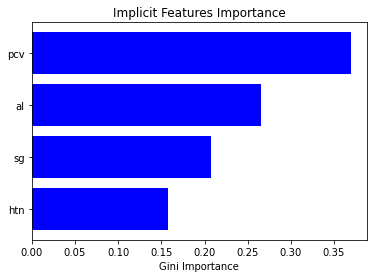

In [51]:
#b)Implicit feature importance
features_selected_xgb=['pcv','htn','sg','al']
importances = xai_clf['clf'].feature_importances_
indices = np.argsort(importances)

plt.title('Implicit Features Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features_selected_xgb[i] for i in indices])
plt.xlabel('Gini Importance')
plt.show()


 

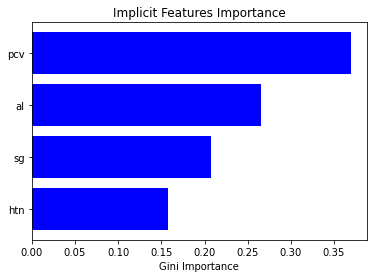

In [52]:
#b)Implicit feature importance
features_selected_xgb=['pcv','htn','sg','al']
estimator=xai_clf['clf']
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.title('Implicit Features Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features_selected_xgb[i] for i in indices])
plt.xlabel('Gini Importance')
plt.show()


 

In [53]:
import eli5
from eli5 import show_weights
eli5.explain_weights(extratree_clf, feature_names=features_selected)

 

C:\Users\k5000751\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\k5000751\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


NameError: name 'features_selected' is not defined

In [54]:
import eli5
from eli5 import show_weights
eli5.explain_weights(estimator, feature_names=features_selected_xgb)

 

Explanation(estimator='XGBClassifier(random_state=42)', description='\nXGBoost feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='pcv', weight=0.3693001, std=None, value=None), FeatureWeight(feature='al', weight=0.26583096, std=None, value=None), FeatureWeight(feature='sg', weight=0.20748805, std=None, value=None), FeatureWeight(feature='htn', weight=0.1573808, std=None, value=None)], remaining=0), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [55]:
#c) Implicit feature importance for local explainability
y_pred = xai_clf.predict(X_test)
print('y_pred',y_pred)
print('y_test',y_test)




>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer
y_pred [1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1
 0 1 0 0 0 1 1 0 0]
y_test [1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1
 0 1 0 0 0 1 1 0 0]


In [56]:
#c) Implicit feature importance for local explainability
X_test_feat_selected=X_test['pcv','htn','sg','al']
y_pred = xai_clf.predict(X_test)
print('y_pred',y_pred)
print('y_test',y_test)


KeyError: ('pcv', 'htn', 'sg', 'al')

In [57]:
#c) Implicit feature importance for local explainability
X_test_feat_selected=X_test[features_selected_xgb]
y_pred = xai_clf.predict(X_test)
print('y_pred',y_pred)
print('y_test',y_test)



>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer
y_pred [1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 1 1
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1
 0 1 0 0 0 1 1 0 0]
y_test [1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1
 0 1 0 0 0 1 1 0 0]


In [58]:
#predicting true negative - the patient DOES HAVE CKD
index_TN = 1
print(X_test_feat_selected.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred_extratree[index_TN])



pcv     32
htn    yes
sg     NaN
al     NaN
Name: 21, dtype: object
Actual Label: 0


NameError: name 'y_pred_extratree' is not defined

In [59]:
#predicting true negative - the patient DOES HAVE CKD
index_TN = 3
print(X_test_feat_selected.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])



pcv    NaN
htn    yes
sg     NaN
al     NaN
Name: 17, dtype: object
Actual Label: 0
Predicted Label: 0


In [60]:
#predicting true negative - the patient DOES HAVE CKD
index_TN = 7
print(X_test_feat_selected.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])



pcv     35
htn    yes
sg     NaN
al     NaN
Name: 160, dtype: object
Actual Label: 0
Predicted Label: 0


In [61]:
#predicting true negative - the patient DOES HAVE CKD
index_TN = 11
print(X_test_feat_selected.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])



pcv       41
htn       no
sg     1.025
al         0
Name: 256, dtype: object
Actual Label: 1
Predicted Label: 1


In [62]:
#predicting true negative - the patient DOES HAVE CKD
index_TN = 12
print(X_test_feat_selected.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])



pcv      33
htn     yes
sg     1.02
al        2
Name: 58, dtype: object
Actual Label: 0
Predicted Label: 0


In [63]:
#predicting true negative - the patient DOES HAVE CKD
index_TN = 12
print(X_test_feat_selected.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])
eli5.explain_prediction(estimator,df_X_test_featsel.iloc[index_TN], feature_names=features_selected_xgb)



pcv      33
htn     yes
sg     1.02
al        2
Name: 58, dtype: object
Actual Label: 0
Predicted Label: 0


NameError: name 'df_X_test_featsel' is not defined

In [64]:
#predicting true negative - the patient DOES HAVE CKD
index_TN = 12
print(X_test_feat_selected.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])
eli5.explain_prediction(estimator,X_test_feat_selected.iloc[index_TN], feature_names=features_selected_xgb)



pcv      33
htn     yes
sg     1.02
al        2
Name: 58, dtype: object
Actual Label: 0
Predicted Label: 0


ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields pcv, htn, sg, al

In [65]:
X_test_feat_selected

pcv  htn     sg   al
id                        
321  48.0   no  1.020  0.0
21   32.0  yes    NaN  NaN
333  46.0   no  1.020  0.0
17    NaN  yes    NaN  NaN
367  50.0   no  1.025  0.0
..    ...  ...    ...  ...
134  33.0   no  1.010  NaN
329  48.0   no  1.025  0.0
392  46.0   no  1.020  0.0
14   16.0  yes  1.010  3.0
13    NaN  yes    NaN  NaN

[120 rows x 4 columns]

In [66]:
#a) The estimator is refited with those feature selected

pipeline_numeric_feat_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean')),
                                 ('scaler', MinMaxScaler())])

numerical_feats_xgb=['pcv']
nominal_feats_xgb=[ 'htn']
ordinal_feats_xgb=['sg','al']

dataprep_merge_feat_xgb=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_mean,numerical_feats_xgb),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_xgb),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats_xgb)
                                    ])

xai_clf=Pipeline([('data_prep',dataprep_merge_feat_xgb),
                          ('clf', xgboost_clf)])

xai_clf.fit(X_train,y_train)



>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


Pipeline(steps=[('data_prep',
                 ColumnTransformer(transformers=[('numeric_pipe',
                                                  Pipeline(steps=[('data_missing',
                                                                   Numeric_Imputer(strategy='mean')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['pcv']),
                                                 ('nominal_pipe',
                                                  Pipeline(steps=[('data_missing',
                                                                   Category_Imputer()),
                                                                  ('encoding',
                                                                   OrdinalEncoder())]),
                                                  ['htn']),
                                

In [67]:
features_selected_xgb=['pcv','htn','sg','al']
X_train_feat_sel=X_train[features_selected_xgb]
X_test_feat_sel=X_test[features_selected_xgb]

In [68]:
X_test_featsel=feat_sel_pipe.fit_transform(X_test_feat_sel)
df_X_test_featsel=pd.DataFrame(X_test_featsel, columns=features_selected_xgb)
df_X_test_featsel.head()


NameError: name 'feat_sel_pipe' is not defined

In [69]:
X_test_featsel=dataprep_merge_feat_xgb.fit_transform(X_test_feat_sel)
df_X_test_featsel=pd.DataFrame(X_test_featsel, columns=features_selected_xgb)
df_X_test_featsel.head()



>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


pcv  htn   sg   al
0  0.866667  0.0  3.0  0.0
1  0.511111  1.0  3.0  0.0
2  0.822222  0.0  3.0  0.0
3  0.653648  1.0  3.0  0.0
4  0.911111  0.0  4.0  0.0

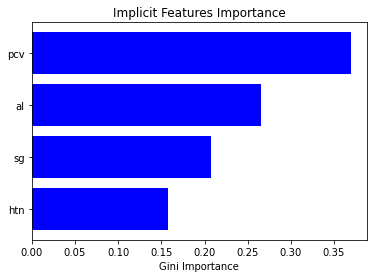

In [70]:
#b)Implicit feature importance

estimator=xai_clf['clf']
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.title('Implicit Features Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features_selected_xgb[i] for i in indices])
plt.xlabel('Gini Importance')
plt.show()


In [71]:
import eli5
from eli5 import show_weights
eli5.explain_weights(estimator, feature_names=features_selected_xgb)

 

Explanation(estimator='XGBClassifier(random_state=42)', description='\nXGBoost feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='pcv', weight=0.3693001, std=None, value=None), FeatureWeight(feature='al', weight=0.26583096, std=None, value=None), FeatureWeight(feature='sg', weight=0.20748805, std=None, value=None), FeatureWeight(feature='htn', weight=0.1573808, std=None, value=None)], remaining=0), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [72]:
#c) Implicit feature importance for local explainability
X_test_feat_selected=X_test[features_selected_xgb]
y_pred = xai_clf.predict(X_test)
print('y_pred',y_pred)
print('y_test',y_test)



>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer
y_pred [1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1
 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1
 0 1 0 0 0 1 1 0 0]
y_test [1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1
 0 1 0 0 0 1 1 0 0]
C:\Users\k5000751\Anaconda3\lib\site-packages\sklearn\compose\_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [73]:
#c) Implicit feature importance for local explainability
X_test_feat_selected=X_test[features_selected_xgb]
y_pred = xai_clf.predict(X_test_feat_sel)
print('y_pred',y_pred)
print('y_test',y_test)



>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer
y_pred [1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1
 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1
 0 1 0 0 0 1 1 0 0]
y_test [1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1
 0 1 0 0 0 1 1 0 0]


In [74]:
#predicting true negative - the patient DOES HAVE CKD
index_TN = 12
print(X_test_feat_selected.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])
eli5.explain_prediction(estimator,df_X_test_featsel.iloc[index_TN], feature_names=features_selected_xgb)



pcv      33
htn     yes
sg     1.02
al        2
Name: 58, dtype: object
Actual Label: 0
Predicted Label: 0


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3'] ['pcv', 'htn', 'sg', 'al']
expected f1, f2, f3, f0 in input data
training data did not have the following fields: sg, al, pcv, htn

In [75]:
#predicting true negative - the patient DOES HAVE CKD
index_TN = 12
print(X_test_feat_selected.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])
eli5.explain_prediction(estimator,X_test_featsel.iloc[index_TN], feature_names=features_selected_xgb)



pcv      33
htn     yes
sg     1.02
al        2
Name: 58, dtype: object
Actual Label: 0
Predicted Label: 0


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [76]:
#predicting true negative - the patient DOES HAVE CKD
index_TN = 12
print(X_test_feat_selected.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])
eli5.explain_prediction(estimator,df_X_test_featsel.iloc[index_TN], feature_names=features_selected_xgb)



pcv      33
htn     yes
sg     1.02
al        2
Name: 58, dtype: object
Actual Label: 0
Predicted Label: 0


ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3'] ['pcv', 'htn', 'sg', 'al']
expected f1, f2, f3, f0 in input data
training data did not have the following fields: sg, al, pcv, htn

In [77]:
X_train_featsel=dataprep_merge_feat_xgb.fit_transform(X_train_feat_sel)
df_X_train_featsel=pd.DataFrame(X_train_featsel, columns=features_selected_xgb)
df_X_train_featsel.head()

X_test_featsel=dataprep_merge_feat_xgb.fit_transform(X_test_feat_sel)
df_X_test_featsel=pd.DataFrame(X_test_featsel, columns=features_selected_xgb)
df_X_test_featsel.head()



>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


pcv  htn   sg   al
0  0.866667  0.0  3.0  0.0
1  0.511111  1.0  3.0  0.0
2  0.822222  0.0  3.0  0.0
3  0.653648  1.0  3.0  0.0
4  0.911111  0.0  4.0  0.0

In [78]:
X_train_featsel=dataprep_merge_feat_xgb.fit_transform(X_train_feat_sel)
df_X_train_featsel=pd.DataFrame(X_train_featsel, columns=features_selected_xgb)
df_X_train_featsel.head()

X_test_featsel=dataprep_merge_feat_xgb.fit_transform(X_test_feat_sel)
df_X_test_featsel=pd.DataFrame(X_test_featsel, columns=features_selected_xgb)
df_X_test_featsel.head()

xgboost_clf.fit(df_X_train_featsel,y_train)



>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


XGBClassifier(random_state=42)

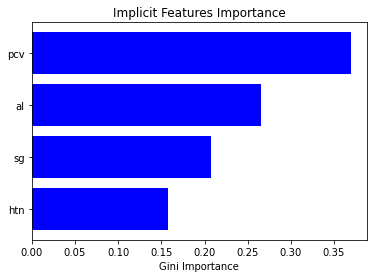

In [79]:
#b)Implicit feature importance

importances = xgboost_clf.feature_importances_
indices = np.argsort(importances)

plt.title('Implicit Features Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features_selected_xgb[i] for i in indices])
plt.xlabel('Gini Importance')
plt.show()


In [80]:
import eli5
from eli5 import show_weights
eli5.explain_weights(estimator, feature_names=features_selected_xgb)

 

Explanation(estimator='XGBClassifier(random_state=42)', description='\nXGBoost feature importances; values are numbers 0 <= x <= 1;\nall values sum to 1.\n', error=None, method='feature importances', is_regression=False, targets=None, feature_importances=FeatureImportances(importances=[FeatureWeight(feature='pcv', weight=0.3693001, std=None, value=None), FeatureWeight(feature='al', weight=0.26583096, std=None, value=None), FeatureWeight(feature='sg', weight=0.20748805, std=None, value=None), FeatureWeight(feature='htn', weight=0.1573808, std=None, value=None)], remaining=0), decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [81]:
#c) Implicit feature importance for local explainability
X_test_feat_selected=X_test[features_selected_xgb]
y_pred = xai_clf.predict(X_test_feat_sel)
print('y_pred',y_pred)
print('y_test',y_test)



>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


ValueError: feature_names mismatch: ['pcv', 'htn', 'sg', 'al'] ['f0', 'f1', 'f2', 'f3']
expected sg, al, pcv, htn in input data
training data did not have the following fields: f1, f2, f3, f0

In [82]:
#c) Implicit feature importance for local explainability
X_test_feat_selected=X_test[features_selected_xgb]
y_pred = xgboost_clf.predict(X_test_feat_sel)
print('y_pred',y_pred)
print('y_test',y_test)


ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields htn, sg, al

In [83]:
#c) Implicit feature importance for local explainability

y_pred = xgboost_clf.predict(df_X_test_featsel)
print('y_pred',y_pred)
print('y_test',y_test)


y_pred [1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1
 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1
 0 1 0 0 0 1 1 0 0]
y_test [1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1
 0 1 0 0 0 1 1 0 0]


In [84]:
#predicting true negative - the patient DOES HAVE CKD
index_TN = 12
print(X_test_feat_selected.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])
eli5.explain_prediction(estimator,df_X_test_featsel.iloc[index_TN], feature_names=features_selected_xgb)



pcv      33
htn     yes
sg     1.02
al        2
Name: 58, dtype: object
Actual Label: 0
Predicted Label: 0


Explanation(estimator='XGBClassifier(random_state=42)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='pcv', weight=2.4099375861095984, std=None, value=0.5333333333333334), FeatureWeight(feature='al', weight=1.2662263942986078, std=None, value=2.0), FeatureWeight(feature='<BIAS>', weight=1.1815591116702298, std=None, value=1.0), FeatureWeight(feature='htn', weight=0.7881442508140045, std=None, value=1.0)], neg=[FeatureWeight(feature='sg', weight=-0.11159066154403982, std=None, value=3.0)], pos_remaining=0, neg_remaining=0), proba=0.99606645, score=-5.534276681348401, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [85]:
#predicting true negative - the patient DOES HAVE CKD
index_TN = 11
print(X_test_feat_selected.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])
eli5.explain_prediction(estimator,df_X_test_featsel.iloc[index_TN], feature_names=features_selected_xgb)


pcv       41
htn       no
sg     1.025
al         0
Name: 256, dtype: object
Actual Label: 1
Predicted Label: 1


Explanation(estimator='XGBClassifier(random_state=42)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='pcv', weight=1.5567664044132699, std=None, value=0.711111111111111), FeatureWeight(feature='sg', weight=1.434827627261301, std=None, value=4.0), FeatureWeight(feature='al', weight=0.7787754155785969, std=None, value=0.0), FeatureWeight(feature='htn', weight=0.5949674847430617, std=None, value=0.0)], neg=[FeatureWeight(feature='<BIAS>', weight=-1.1815591116702298, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.96021926, score=3.183777820326001, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [86]:
#d) Feature permutation importance
perm=PermutationImportance(xgboost_clf).fit(df_X_test_featsel,y_test)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=numerical_features)
feat_perm_df

NameError: name 'PermutationImportance' is not defined

In [87]:
#d) Feature permutation importance
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(xgboost_clf).fit(df_X_test_featsel,y_test)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=numerical_features)
feat_perm_df

NameError: name 'numerical_features' is not defined

In [88]:
#d) Feature permutation importance
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(xgboost_clf).fit(df_X_test_featsel,y_test)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=features_selected_xgb)
feat_perm_df

feature    weight       std
0      sg  0.166667  0.031180
1     htn  0.126667  0.036667
2     pcv  0.126667  0.023214
3      al  0.025000  0.011785

In [89]:
#d) Feature permutation importance
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(xgboost_clf).fit(df_X_test_featsel,y_test)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=features_selected_xgb)
feat_perm_df_pivot=feat_perm_df.pivot_table(columns='feature', values='weight')   
feat_perm_array_iteration={'sg':feat_perm_df_pivot['sg'],
                              'htn':feat_perm_df_pivot['htn'],
                              'pcv':feat_perm_df_pivot['pcv'],
                              'al':feat_perm_df_pivot['al']}
df_feat_perm_array_iteration= pd.DataFrame(data=feat_perm_array_iteration)
df_feat_perm_array_iteration

sg   htn   pcv        al
weight  0.155  0.16  0.12  0.028333

In [90]:
#d) Feature permutation importance
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(xgboost_clf).fit(df_X_test_featsel,y_test)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=features_selected_xgb)
feat_perm_df_pivot=feat_perm_df.pivot_table(columns='feature', values=['weight','std'])   
feat_perm_array_iteration={'sg':feat_perm_df_pivot['sg'],
                              'htn':feat_perm_df_pivot['htn'],
                              'pcv':feat_perm_df_pivot['pcv'],
                              'al':feat_perm_df_pivot['al']}
df_feat_perm_array_iteration= pd.DataFrame(data=feat_perm_array_iteration)
df_feat_perm_array_iteration

sg       htn       pcv        al
std     0.019293  0.020138  0.020138  0.009718
weight  0.135000  0.121667  0.130000  0.010000

In [91]:
#d) Feature permutation importance
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(xgboost_clf).fit(df_X_test_featsel,y_test)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=features_selected_xgb)
feat_perm_df_pivot=feat_perm_df.pivot_table(columns='feature', values=['weight','std'])   
feat_perm_array_iteration={'sg':feat_perm_df_pivot['sg'],
                              'htn':feat_perm_df_pivot['htn'],
                              'pcv':feat_perm_df_pivot['pcv'],
                              'al':feat_perm_df_pivot['al']}
df_feat_perm_array_iteration= pd.DataFrame(data=feat_perm_array_iteration)
df_feat_perm_array_iteration

sg       htn       pcv        al
std     0.012472  0.024495  0.025276  0.011304
weight  0.153333  0.121667  0.141667  0.020000

In [92]:
#d) Feature permutation importance
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(xgboost_clf).fit(df_X_test_featsel,y_test)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=features_selected_xgb)
feat_perm_df


feature    weight       std
0      sg  0.158333  0.029345
1     htn  0.125000  0.044410
2     pcv  0.118333  0.023805
3      al  0.033333  0.007454

In [93]:
#d) Feature permutation importance
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(xgboost_clf).fit(df_X_test_featsel,y_test)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=features_selected_xgb)
feat_perm_df


feature    weight       std
0      sg  0.158333  0.027889
1     htn  0.130000  0.015456
2     pcv  0.126667  0.021985
3      al  0.020000  0.011304

In [94]:
#d) Feature permutation importance
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(xgboost_clf).fit(df_X_test_featsel,y_test)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=features_selected_xgb)
feat_perm_df


feature    weight       std
0      sg  0.163333  0.014530
1     htn  0.135000  0.013333
2     pcv  0.113333  0.010000
3      al  0.038333  0.016330

In [95]:
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 10.27)
ax.bar(feat_perm_df['feature'], feat_perm_df['weight'], yerr=feat_perm_df['std'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Importance')
ax.set_xticks(result['feature'])
ax.set_xticklabels(result['feature'])
ax.set_title('Feature Permutation importance distribution')
ax.yaxis.grid(True)


NameError: name 'result' is not defined

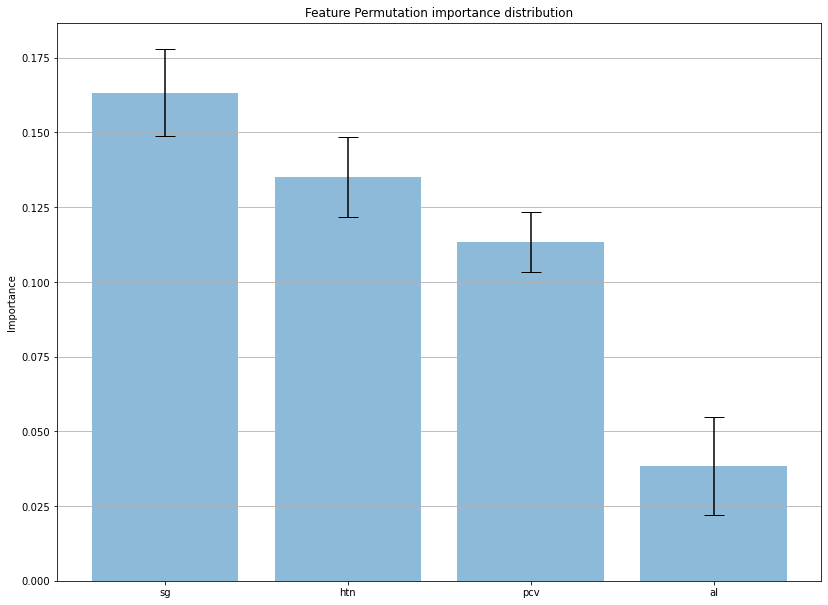

In [96]:
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 10.27)
ax.bar(feat_perm_df['feature'], feat_perm_df['weight'], yerr=feat_perm_df['std'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Importance')
ax.set_xticks(feat_perm_df['feature'])
ax.set_xticklabels(feat_perm_df['feature'])
ax.set_title('Feature Permutation importance distribution')
ax.yaxis.grid(True)


In [97]:
#d) Feature permutation importance
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(xgboost_clf).fit(df_X_test_featsel,y_test)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=features_selected_xgb)
feat_perm_df


feature    weight       std
0      sg  0.153333  0.015456
1     pcv  0.138333  0.022730
2     htn  0.116667  0.026874
3      al  0.021667  0.013540

In [98]:
feat_perm_df_pivot=feat_perm_df.pivot_table(columns='feature', values=['weight','std'])   
feat_perm_array_iteration={'sg':feat_perm_df_pivot['sg'],
                              'htn':feat_perm_df_pivot['htn'],
                              'pcv':feat_perm_df_pivot['pcv'],
                              'al':feat_perm_df_pivot['al']}
df_feat_perm_array_iteration= pd.DataFrame(data=feat_perm_array_iteration)
df_feat_perm_array_iteration


sg       htn       pcv        al
std     0.015456  0.026874  0.022730  0.013540
weight  0.153333  0.116667  0.138333  0.021667

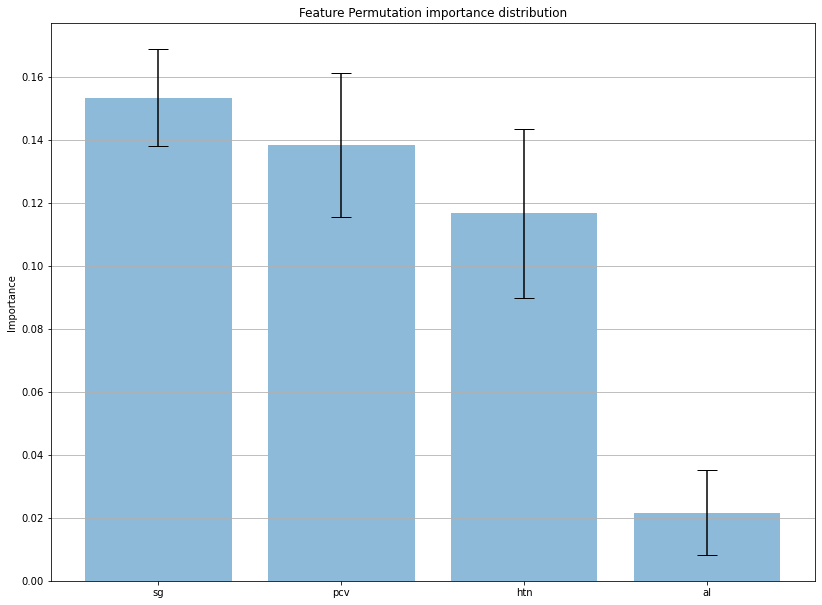

In [99]:
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 10.27)
ax.bar(feat_perm_df['feature'], feat_perm_df['weight'], yerr=feat_perm_df['std'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Importance')
ax.set_xticks(feat_perm_df['feature'])
ax.set_xticklabels(feat_perm_df['feature'])
ax.set_title('Feature Permutation importance distribution')
ax.yaxis.grid(True)


In [100]:
#d) Feature permutation importance
#############################################################
# With X_train
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(xgboost_clf).fit(df_X_train_featsel,y_train)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=features_selected_xgb)
feat_perm_df


feature    weight       std
0     pcv  0.233571  0.019769
1      sg  0.162143  0.006624
2     htn  0.092143  0.013814
3      al  0.048571  0.003642

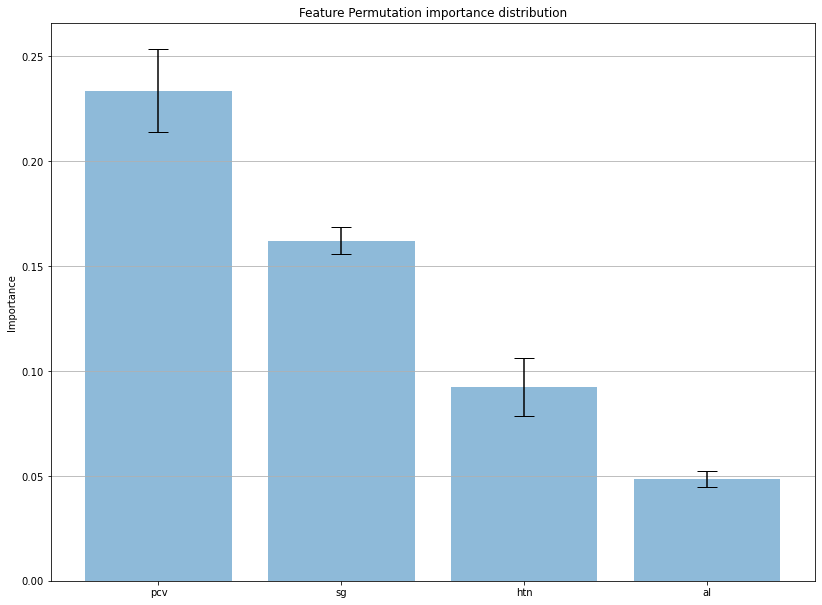

In [101]:
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 10.27)
ax.bar(feat_perm_df['feature'], feat_perm_df['weight'], yerr=feat_perm_df['std'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Importance')
ax.set_xticks(feat_perm_df['feature'])
ax.set_xticklabels(feat_perm_df['feature'])
ax.set_title('Feature Permutation importance distribution')
ax.yaxis.grid(True)


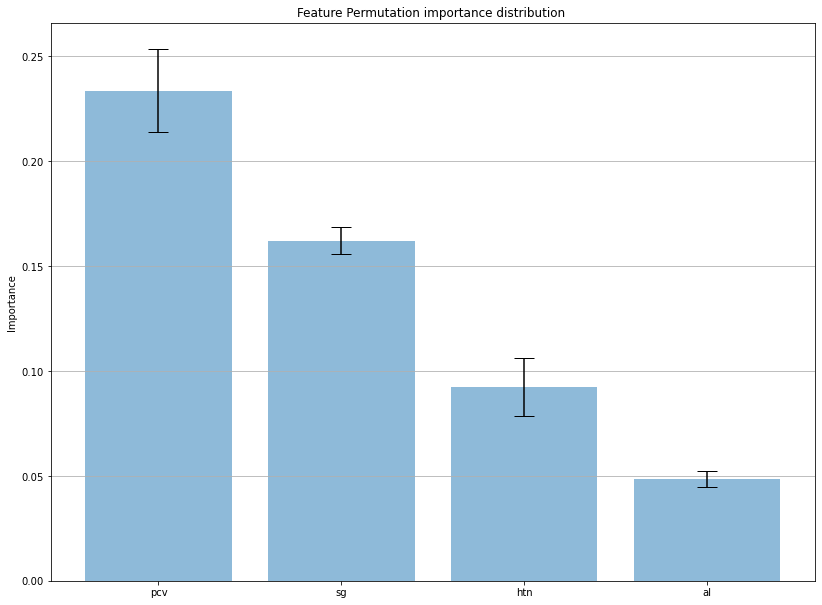

In [102]:
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 10.27)
ax.bar(feat_perm_df['feature'], feat_perm_df['weight'], yerr=feat_perm_df['std'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Importance')
ax.set_xticks(feat_perm_df['feature'])
ax.set_xticklabels(feat_perm_df['feature'])
ax.set_title('Feature Permutation importance distribution ')
ax.yaxis.grid(True)


In [103]:
# With X_test
from eli5.sklearn import PermutationImportance
perm=PermutationImportance(xgboost_clf).fit(df_X_test_featsel,y_test)
feat_perm_df=eli5.explain_weights_df(perm,feature_names=features_selected_xgb)
feat_perm_df


feature    weight       std
0      sg  0.183333  0.016667
1     htn  0.175000  0.024152
2     pcv  0.131667  0.014337
3      al  0.026667  0.006236

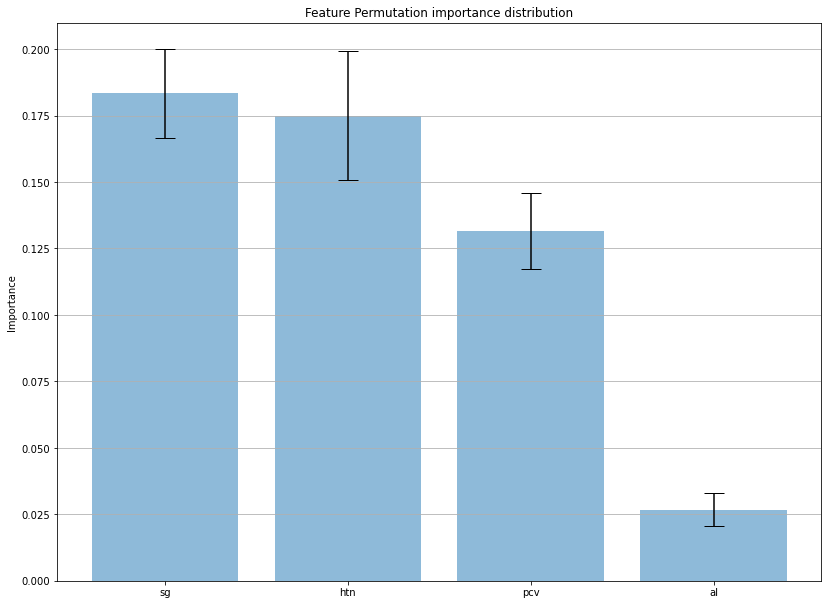

In [104]:
fig, ax = plt.subplots()
fig.set_size_inches(13.7, 10.27)
ax.bar(feat_perm_df['feature'], feat_perm_df['weight'], yerr=feat_perm_df['std'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Importance')
ax.set_xticks(feat_perm_df['feature'])
ax.set_xticklabels(feat_perm_df['feature'])
ax.set_title('Feature Permutation importance distribution')
ax.yaxis.grid(True)


In [130]:
pipeline_numeric_imputer_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean'))])

pipeline_nominal_imputer=Pipeline([('data_missing',missing_val_imput.Category_Imputer())])#We dont use OneHotEncoder since it enlarges the number of nominal features 

pipeline_ordinal_imputer=Pipeline([ ('data_missing',missing_val_imput.Category_Imputer(strategy='most_frequent'))])

dataimputer_pipe=ColumnTransformer([('numeric_pipe',pipeline_numeric_imputer_mean,numerical_feats_xgb),
                                    ('nominal_pipe',pipeline_nominal_imputer,nominal_feats_xgb),
                                    ('ordinal_pipe',pipeline_ordinal_imputer,ordinal_feats_xgb)
                                ])

X_train_imputed=dataimputer_pipe.fit_transform(X_train_feat_sel)
df_X_train_imputed=pd.DataFrame(X_train_imputed, columns=features_selected_xgb)
df_X_train_imputed.head()



>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


pcv  htn     sg al
0  28  yes  1.015  0
1  52   no   1.02  0
2  48   no  1.025  0
3  52   no  1.025  0
4  44   no   1.01  0

In [136]:
pipeline_numeric_imputer_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean'))])

pipeline_nominal_imputer=Pipeline([('data_missing',missing_val_imput.Category_Imputer()),
                                 ('encoding', OrdinalEncoder())])#We dont use OneHotEncoder since it enlarges the number of nominal features 

pipeline_ordinal_imputer=Pipeline([ ('data_missing',missing_val_imput.Category_Imputer(strategy='most_frequent'))])

dataimputer_pipe=ColumnTransformer([('numeric_pipe',pipeline_numeric_imputer_mean,numerical_feats_xgb),
                                    ('nominal_pipe',pipeline_nominal_imputer,nominal_feats_xgb),
                                    ('ordinal_pipe',pipeline_ordinal_imputer,ordinal_feats_xgb)
                                ])

X_train_imputed=dataimputer_pipe.fit_transform(X_train_feat_sel)
df_X_train_imputed=pd.DataFrame(X_train_imputed, columns=features_selected_xgb)
df_X_train_imputed.head()



>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


pcv htn     sg al
0  28   1  1.015  0
1  52   0   1.02  0
2  48   0  1.025  0
3  52   0  1.025  0
4  44   0   1.01  0


>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling tra

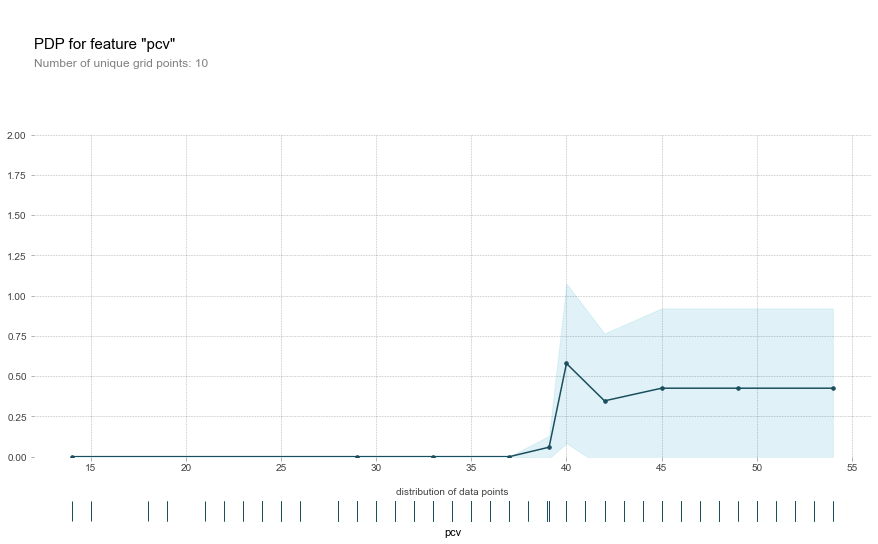

In [137]:
pipe_pdp_xgb=Pipeline([('data_prep',dataprep_merge_feat_xgb),
                          ('clf', dectree_clf)])

model=pipe_pdp_xgb.fit(df_X_train_imputed,y_train)

pdp_age_Xtrain= pdp.pdp_isolate(model=model, dataset=df_X_train_imputed, model_features=df_X_train_imputed.columns, feature='pcv')
fig,axes=pdp.pdp_plot(pdp_age_Xtrain, 'pcv',plot_pts_dist=True, frac_to_plot=0.5)
axes['pdp_ax']['_pdp_ax'].set_ylim(ymin=0, ymax=2)
plt.show()


>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


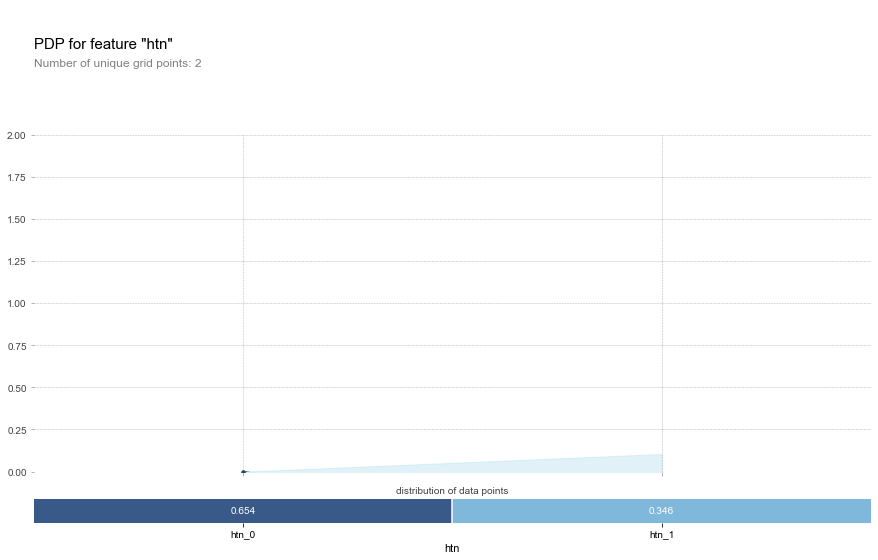

In [138]:
pdp_age_Xtrain= pdp.pdp_isolate(model=model, dataset=df_X_train_imputed, model_features=df_X_train_imputed.columns, feature='htn')
fig,axes=pdp.pdp_plot(pdp_age_Xtrain, 'htn',plot_pts_dist=True, frac_to_plot=0.5)
axes['pdp_ax']['_pdp_ax'].set_ylim(ymin=0, ymax=2)
plt.show()



>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


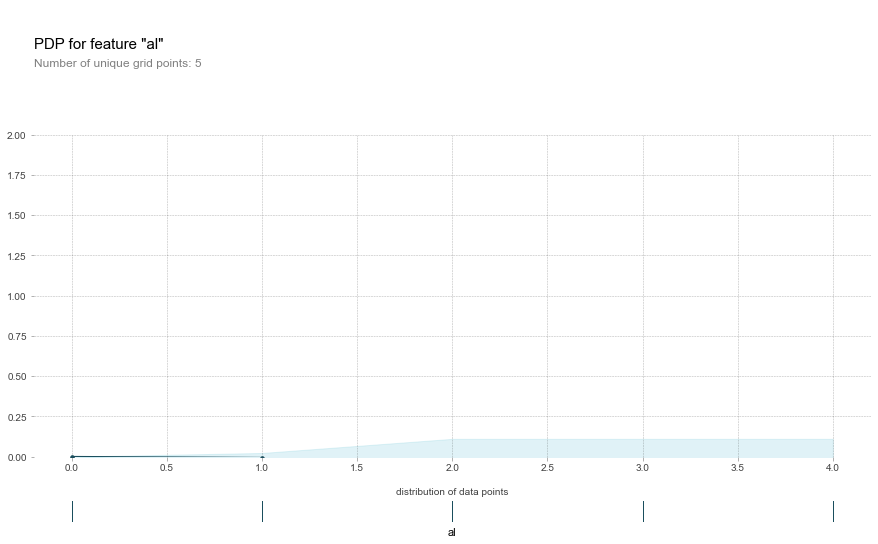

In [139]:
pdp_age_Xtrain= pdp.pdp_isolate(model=model, dataset=df_X_train_imputed, model_features=df_X_train_imputed.columns, feature='al')
fig,axes=pdp.pdp_plot(pdp_age_Xtrain, 'al',plot_pts_dist=True, frac_to_plot=0.5)
axes['pdp_ax']['_pdp_ax'].set_ylim(ymin=0, ymax=2)
plt.show()



>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


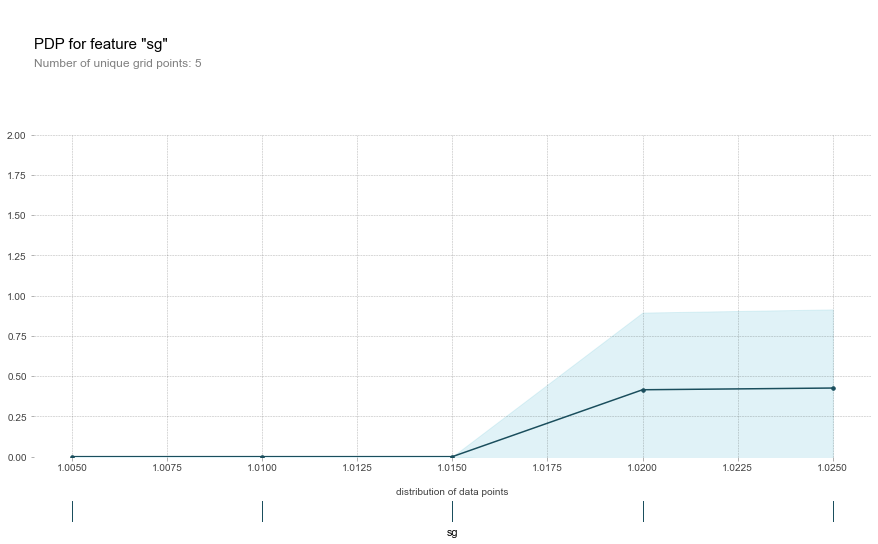

In [140]:
pdp_age_Xtrain= pdp.pdp_isolate(model=model, dataset=df_X_train_imputed, model_features=df_X_train_imputed.columns, feature='sg')
fig,axes=pdp.pdp_plot(pdp_age_Xtrain, 'sg',plot_pts_dist=True, frac_to_plot=0.5)
axes['pdp_ax']['_pdp_ax'].set_ylim(ymin=0, ymax=2)
plt.show()

In [141]:
#e) SHAP explainability
#####################################################

import shap
shap.initjs()

pipe_shap_xgb=Pipeline([('data_prep',dataprep_merge_feat_xgb),
                          ('clf', dectree_clf)])

explainer=shap.explainers.Tree(pipe_shap_xgb.named_steps['clf'], pipe_shap_xgb.named_steps['data_prep'].fit_transform(df_X_train_imputed))
shap_values=explainer.shap_values(pipe_shap_xgb.named_steps['data_prep'].fit_transform(df_X_train_imputed))



>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


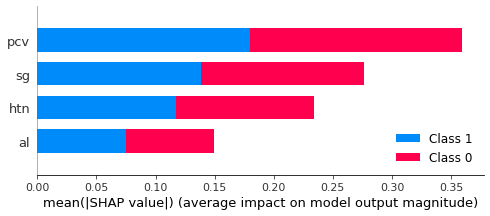

In [142]:
shap.summary_plot(shap_values, df_X_train_featsel,plot_type="bar")

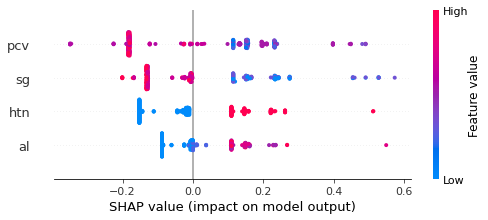

In [143]:
shap.summary_plot(shap_values[0], df_X_train_featsel,plot_type="dot")

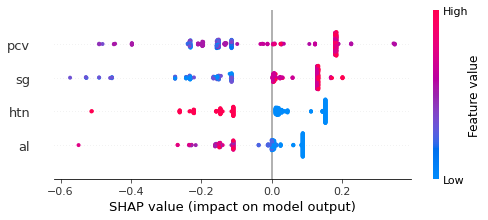

In [144]:
shap.summary_plot(shap_values[1], df_X_train_featsel,plot_type="dot")

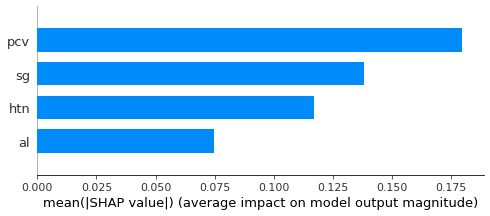

In [145]:
shap.summary_plot(shap_values[0], df_X_train_featsel,plot_type="bar")

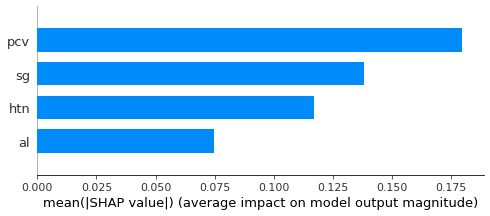

In [146]:
shap.summary_plot(shap_values[1], df_X_train_featsel,plot_type="bar")

In [147]:
#c) Implicit feature importance for local explainability
###############################################################

y_pred = xgboost_clf.predict(df_X_test_featsel)
print('y_pred',y_pred)
print('y_test',y_test)


y_pred [1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1
 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1
 0 1 0 0 0 1 1 0 0]
y_test [1 0 1 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 1
 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 1 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1
 0 1 0 0 0 1 1 0 0]


In [148]:
#predicting true negative - the patient DOES HAVE CKD
index_TN = 12
print(df_X_test_featsel.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])
eli5.explain_prediction(xgboost_clf,df_X_test_featsel.iloc[index_TN], feature_names=features_selected_xgb)



pcv    0.533333
htn    1.000000
sg     3.000000
al     2.000000
Name: 12, dtype: float64
Actual Label: 0
Predicted Label: 0


Explanation(estimator='XGBClassifier(random_state=42)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='pcv', weight=2.4099375861095984, std=None, value=0.5333333333333334), FeatureWeight(feature='al', weight=1.2662263942986078, std=None, value=2.0), FeatureWeight(feature='<BIAS>', weight=1.1815591116702298, std=None, value=1.0), FeatureWeight(feature='htn', weight=0.7881442508140045, std=None, value=1.0)], neg=[FeatureWeight(feature='sg', weight=-0.11159066154403982, std=None, value=3.0)], pos_remaining=0, neg_remaining=0), proba=0.99606645, score=-5.534276681348401, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [149]:
#predicting true negative - the patient DOES HAVE CKD
index_TP = 11
print(df_X_test_featsel.iloc[index_TP])
print('Actual Label:', y_test[index_TP])
print('Predicted Label:', y_pred[index_TP])
eli5.explain_prediction(xgboost_clf,df_X_test_featsel.iloc[index_TP], feature_names=features_selected_xgb)


pcv    0.711111
htn    0.000000
sg     4.000000
al     0.000000
Name: 11, dtype: float64
Actual Label: 1
Predicted Label: 1


Explanation(estimator='XGBClassifier(random_state=42)', description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='pcv', weight=1.5567664044132699, std=None, value=0.711111111111111), FeatureWeight(feature='sg', weight=1.434827627261301, std=None, value=4.0), FeatureWeight(feature='al', weight=0.7787754155785969, std=None, value=0.0), FeatureWeight(feature='htn', weight=0.5949674847430617, std=None, value=0.0)], neg=[FeatureWeight(feature='<BIAS>', weight=-1.1815591116702298, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.96021926, score=3.183777820326001, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)

In [150]:
#f) SHAP explainability - local explainability
##########################################################
choosen_instance_tn=X_train_feat_selected.loc[[index_TN]]
choosen_instance_tn

NameError: name 'X_train_feat_selected' is not defined

In [151]:
#f) SHAP explainability - local explainability
##########################################################
choosen_instance_tn=X_train_feat_sel.loc[[index_TN]]
choosen_instance_tn

pcv  htn     sg   al
id                       
12  28.0  yes  1.015  3.0

In [152]:
#f) SHAP explainability - local explainability
##########################################################
choosen_instance_tn=df_X_train_imputed.loc[[index_TN]]
choosen_instance_tn


pcv htn     sg al
12  51   0  1.025  0

In [153]:
print(df_X_train_imputed.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred_extratree[index_TN])


pcv       51
htn        0
sg     1.025
al         0
Name: 12, dtype: object
Actual Label: 0


NameError: name 'y_pred_extratree' is not defined

In [154]:
print(df_X_train_imputed.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])


pcv       51
htn        0
sg     1.025
al         0
Name: 12, dtype: object
Actual Label: 0
Predicted Label: 0


In [155]:
shap_values_tn = explainer.shap_values(choosen_instance_tn)
shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)
shap.force_plot(explainer.expected value, shapshap_values[index,:], X_train_feat_selected.iloc[index,:])

SyntaxError: invalid syntax (<ipython-input-155-9417a9a57ca5>, line 4)

In [156]:
shap_values_tn = explainer.shap_values(choosen_instance_tn)
shap.initjs()
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)
#shap.force_plot(explainer.expected value, shapshap_values[index,:], X_train_feat_selected.iloc[index,:])

Exception: The waterfall_plot can currently only plot a single explanation but a matrix of explanations was passed!

In [157]:
shap_values_tn = explainer.shap_values(choosen_instance_tn)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)

In [158]:
#f) SHAP explainability - local explainability
##########################################################

print(df_X_train_imputed.iloc[index_TN])
print('Actual Label:', y_train[index_TN])
print('Predicted Label:', y_pred[index_TN])
choosen_instance_tn=df_X_train_imputed.loc[[index_TN]]
shap_values_tn = explainer.shap_values(choosen_instance_tn)


pcv       51
htn        0
sg     1.025
al         0
Name: 12, dtype: object
Actual Label: 1
Predicted Label: 0


In [159]:
#f) SHAP explainability - local explainability
##########################################################
X_test_imputed=dataimputer_pipe.fit_transform(X_test_feat_sel)
df_X_test_imputed=pd.DataFrame(X_test_imputed, columns=features_selected_xgb)
df_X_test_imputed.head()



>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


pcv htn     sg al
0       48   0   1.02  0
1       32   1   1.02  0
2       46   0   1.02  0
3  38.4141   1   1.02  0
4       50   0  1.025  0

In [160]:
print(df_X_test_imputed.iloc[index_TN])
print('Actual Label:', y_train[index_TN])
print('Predicted Label:', y_pred[index_TN])
choosen_instance_tn=df_X_train_imputed.loc[[index_TN]]
shap_values_tn = explainer.shap_values(choosen_instance_tn)


pcv      33
htn       1
sg     1.02
al        2
Name: 12, dtype: object
Actual Label: 1
Predicted Label: 0


In [161]:
print(df_X_test_imputed.iloc[index_TN])
print('Actual Label:', y_test[index_TN])
print('Predicted Label:', y_pred[index_TN])
choosen_instance_tn=df_X_test_imputed.loc[[index_TN]]
shap_values_tn = explainer.shap_values(choosen_instance_tn)


pcv      33
htn       1
sg     1.02
al        2
Name: 12, dtype: object
Actual Label: 0
Predicted Label: 0


In [162]:
#XGBoost
pipeline_numeric_feat_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean')),
                                 ('scaler', MinMaxScaler())])

numerical_feats_xgb=['pcv']
nominal_feats_xgb=[ 'htn']
ordinal_feats_xgb=['sg','al']

dataprep_merge_feat_xgb=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_mean,numerical_feats_xgb),
                                    ('nominal_pipe',pipeline_nominal_feat, nominal_feats_xgb),
                                    ('ordinal_pipe',pipeline_ordinal_feat,ordinal_feats_xgb)
                                    ])

pipe_fidelity_xgb=Pipeline([('data_prep',dataprep_merge_feat_xgb),
                          ('clf', dectree_clf)])

pipe_fidelity_xgb.fit(X_train,y_train)
y_pred_fidelity_xgb = pipe_fidelity_xgb.predict(X_test)
accuracy_score(y_test, y_pred_fidelity_xgb)#0.975



>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


0.975

In [163]:
#f) SHAP explainability - local explainability
##########################################################

y_pred_train= pipe_fidelity_xgb.predict(X_train_feat_sel)

ValueError: Number of features of the input must be equal to or greater than that of the fitted transformer. Transformer n_features is 24 and input n_features is 4.

In [164]:
#f) SHAP explainability - local explainability
##########################################################

pipe_fidelity_xgb.fit(X_train_feat_sel)
y_pred_train= pipe_fidelity_xgb.predict(X_train_feat_sel)


>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


ValueError: This DecisionTreeClassifier estimator requires y to be passed, but the target y is None.

In [165]:
#f) SHAP explainability - local explainability
##########################################################

pipe_fidelity_xgb.fit(X_train_feat_sel,y_train)
y_pred_train= pipe_fidelity_xgb.predict(X_train_feat_sel)


>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


In [166]:
print(df_X_train_imputed.iloc[index_TN])
print('Actual Label:', y_train[index_TN])
print('Predicted Label:', y_pred_train[index_TN])
choosen_instance_tn=df_X_test_imputed.loc[[index_TN]]
shap_values_tn = explainer.shap_values(choosen_instance_tn)


pcv       51
htn        0
sg     1.025
al         0
Name: 12, dtype: object
Actual Label: 1
Predicted Label: 1


In [167]:
print('y_train',y_train)
print('y_pred_train',y_pred_train)


y_train [0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0
 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1
 1 0 1 1 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0
 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0
 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0
 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1
 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1]
y_pred_train [0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0
 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1
 1 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0
 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0
 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0 0 0
 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 

In [168]:
index_TN_shap=0
print(df_X_train_imputed.iloc[index_TN_shap])
print('Actual Label:', y_train[index_TN_shap])
print('Predicted Label:', y_pred_train[index_TN_shap])
choosen_instance_tn=df_X_test_imputed.loc[[index_TN_shap]]
shap_values_tn = explainer.shap_values(choosen_instance_tn)


pcv       28
htn        1
sg     1.015
al         0
Name: 0, dtype: object
Actual Label: 0
Predicted Label: 0


In [169]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)
#shap.force_plot(explainer.expected value, shapshap_values[index,:], X_train_feat_selected.iloc[index,:])


Exception: The waterfall_plot can currently only plot a single explanation but a matrix of explanations was passed!

In [170]:
shap_values_tn = explainer.shap_values(choosen_instance_tn)
shap.force_plot(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)

In [171]:
#True negative instance
index_TN_shap=1
print(df_X_train_imputed.iloc[index_TN_shap])
print('Actual Label:', y_train[index_TN_shap])
print('Predicted Label:', y_pred_train[index_TN_shap])
choosen_instance_tn=df_X_test_imputed.loc[[index_TN_shap]]
shap_values_tn = explainer.shap_values(choosen_instance_tn)


pcv      52
htn       0
sg     1.02
al        0
Name: 1, dtype: object
Actual Label: 1
Predicted Label: 1


In [172]:
shap_values_tn = explainer.shap_values(choosen_instance_tn)
shap.force_plot(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)

In [173]:
shap_values_tn = explainer.shap_values(choosen_instance_tn)
shap.force_plot(explainer.expected_value[1], shap_values_tn[1], choosen_instance_tn)

In [174]:
explainer

In [175]:
explainer.expected_value

array([0.55333333, 0.44666667])

In [176]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values_tn[1], choosen_instance_tn)
#shap.force_plot(explainer.expected value, shapshap_values[index,:], X_train_feat_selected.iloc[index,:])

Exception: The waterfall_plot can currently only plot a single explanation but a matrix of explanations was passed!

In [177]:
#True negative instance
index_TP_shap=1
print(df_X_train_imputed.iloc[index_TP_shap])
print('Actual Label:', y_train[index_TP_shap])
print('Predicted Label:', y_pred_train[index_TP_shap])
choosen_instance_tp=df_X_test_imputed.loc[[index_TP_shap]]
shap_values_tp = explainer.shap_values(choosen_instance_tp)


pcv      52
htn       0
sg     1.02
al        0
Name: 1, dtype: object
Actual Label: 1
Predicted Label: 1


In [178]:
shap_values_tp = explainer.shap_values(choosen_instance_tp)
shap.force_plot(explainer.expected_value[1], shap_values_tp[1], choosen_instance_tp)

In [179]:
shap_values_tp = explainer.shap_values(choosen_instance_tp)
shap.force_plot(explainer.expected_value[0], shap_values_tp[0], choosen_instance_tp)

In [180]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)
#shap.force_plot(explainer.expected value, shapshap_values[index,:], X_train_feat_selected.iloc[index,:])



Exception: The waterfall_plot can currently only plot a single explanation but a matrix of explanations was passed!

In [181]:
shap_values_tn[0]


array([[-0.00349206,  0.2231746 ,  0.2281746 , -0.00119048]])

In [182]:
explainer.expected_value[0]


0.5533333333333332

In [183]:
shap.plots._waterfall.waterfall_legacy(shap_values_tn[0], explainer.expected_value[0], choosen_instance_tn)
#shap.force_plot(explainer.expected value, shapshap_values[index,:], X_train_feat_selected.iloc[index,:])


Exception: waterfall_plot requires a scalar expected_value of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.expected_value[0], shap_values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.expected_value[0], shap_values[0][0], X[0]).

In [184]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_tn[0][0], choosen_instance_tn)
#shap.force_plot(explainer.expected value, shapshap_values[index,:], X_train_feat_selected.iloc[index,:])


KeyError: 2

In [185]:
#f) SHAP explainability - local explainability
##########################################################

pipe_fidelity_xgb.fit(X_train_feat_sel,y_train)
y_pred_train= pipe_fidelity_xgb.predict(X_train_feat_sel)



>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


In [186]:
#True negative instance
index_TN_shap=0
print(df_X_train_imputed.iloc[index_TN_shap])
print('Actual Label:', y_train[index_TN_shap])
print('Predicted Label:', y_pred_train[index_TN_shap])
choosen_instance_tn=df_X_train_imputed.loc[[index_TN_shap]]
shap_values_tn = explainer.shap_values(choosen_instance_tn)


pcv       28
htn        1
sg     1.015
al         0
Name: 0, dtype: object
Actual Label: 0
Predicted Label: 0


In [187]:
shap_values_tn = explainer.shap_values(choosen_instance_tn)
shap.force_plot(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)


In [188]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_tn[0][0], choosen_instance_tn)
#shap.force_plot(explainer.expected value, shapshap_values[index,:], X_train_feat_selected.iloc[index,:])


KeyError: 2

In [189]:
#True negative instance
index_TP_shap=1
print(df_X_train_imputed.iloc[index_TP_shap])
print('Actual Label:', y_train[index_TP_shap])
print('Predicted Label:', y_pred_train[index_TP_shap])
choosen_instance_tp=df_X_train_imputed.loc[[index_TP_shap]]
shap_values_tp = explainer.shap_values(choosen_instance_tp)


pcv      52
htn       0
sg     1.02
al        0
Name: 1, dtype: object
Actual Label: 1
Predicted Label: 1


In [190]:
shap_values_tp = explainer.shap_values(choosen_instance_tp)
shap.force_plot(explainer.expected_value[0], shap_values_tp[0], choosen_instance_tp)

In [191]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values_tn[1], choosen_instance_tn)
#shap.force_plot(explainer.expected value, shapshap_values[index,:], X_train_feat_selected.iloc[index,:])

Exception: The waterfall_plot can currently only plot a single explanation but a matrix of explanations was passed!

In [192]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_tn[0][0], choosen_instance_tn)
#shap.force_plot(explainer.expected value, shapshap_values[index,:], X_train_feat_selected.iloc[index,:])


KeyError: 2

In [193]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)
#shap.force_plot(explainer.expected value, shapshap_values[index,:], X_train_feat_selected.iloc[index,:])


Exception: The waterfall_plot can currently only plot a single explanation but a matrix of explanations was passed!

In [194]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_tn[0,:], choosen_instance_tn)
#shap.force_plot(explainer.expected value, shapshap_values[index,:], X_train_feat_selected.iloc[index,:])


TypeError: list indices must be integers or slices, not tuple

In [195]:
shap.waterfall_plot(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)

AttributeError: 'numpy.float64' object has no attribute 'base_values'

In [196]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values_tn[0], features = choosen_instance_tn)

Exception: waterfall_plot requires a scalar expected_value of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.expected_value[0], shap_values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.expected_value[0], shap_values[0][0], X[0]).

In [197]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[], shap_values_tn[0], choosen_instance_tn[0])

SyntaxError: invalid syntax (<ipython-input-197-9cbde720c87f>, line 1)

In [198]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn[0])

KeyError: 0

In [199]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)

Exception: The waterfall_plot can currently only plot a single explanation but a matrix of explanations was passed!

In [200]:
shap.waterfall_plot(shap.Explanation(values=shap_values_tn[0], 
                                         base_values=explainer.expected_value[0], 
                                         data=choosen_instance_tn,  # added this line
                                         feature_names=df_X_train_imputed.columns.tolist())
                       )

KeyError: 0

In [201]:
shap.plots.waterfall(shap_values[0])


AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

In [202]:
shap.plots.waterfall(shap_values[0][0])


AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

In [203]:
# compute SHAP values

shap_values=explainer(pipe_shap_xgb.named_steps['data_prep'].fit_transform(df_X_train_imputed))



>>>>>>>>Calling init() from Numeric_Imputer

>>>>>>>>Calling fit() from Numeric_Imputer

>>>>>>>>Calling transform() from Numeric_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer

>>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling fit() from Category_Imputer

>>>>>>>>Calling transform() from Category_Imputer


In [204]:
shap.plots.waterfall(shap_values[0])


Exception: waterfall_plot requires a scalar base_values of the model output as the first parameter, but you have passed an array as the first parameter! Try shap.waterfall_plot(explainer.base_values[0], values[0], X[0]) or for multi-output models try shap.waterfall_plot(explainer.base_values[0], values[0][0], X[0]).

In [205]:
shap.plots.waterfall(explainer.base_values[0],shap_values[0], df_X_train_imputed[0]), 


AttributeError: 'Tree' object has no attribute 'base_values'

In [206]:
shap.waterfall_plot(explainer.base_values[0],shap_values[0], df_X_train_imputed[0]), 


AttributeError: 'Tree' object has no attribute 'base_values'

In [207]:
shap.waterfall_plot(shap_values[0], df_X_train_imputed[0]), 


KeyError: 0

In [208]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values_tn[0], choosen_instance_tn)
#shap.force_plot(explainer.expected value, shapshap_values[index,:], X_train_feat_selected.iloc[index,:])
                       

Exception: The waterfall_plot can currently only plot a single explanation but a matrix of explanations was passed!